# MECANISMO BIELA-MANIVELA INVERTIDA

## ANIMACIÓN

In [1]:
import numpy as np
import math as math
import array as arr
import pprint  # para depurar
import matplotlib.pyplot as plt  #Para graficas
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
#%matplotlib inline (Para notebook)



print ('BIELA-MANIVELA INVERTIDA')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["L3"] = float (input ('Introduce longitud L3: '))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["beta"] = float (input ('Introduce angulo inicial beta: '))
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["YB"] = float (input ('Introduce coordenada en y del punto B:'))
meca["XA"] = 0
meca["YA"] = 0

# Defino posicion inicial:
q = np.array ([[0.1], [0.2], [1], [0.2], [meca["XB"]+meca["L3"]*math.cos(meca["beta"])], [meca["YB"]+meca["L3"]*math.sin(meca["beta"])], [meca["theta"]], [meca["beta"]]])
print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((8,8))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,4] = -2*(meca["XB"]-X3)
    Jacob[2,5] = -2*(meca["YB"]-Y3)
    Jacob[3,0] = -(Y2-Y1) + (Y3-Y1)
    Jacob[3,1] = (X2-X1) - (X3-X1)
    Jacob[3,2] = -(Y3-Y1)
    Jacob[3,3] = X3-X1
    Jacob[3,4] = (Y2-Y1)
    Jacob[3,5] = -(X2-X1)

    if (abs(math.cos(theta)) < 0.95 ):
        Jacob[4,6] = meca["L1"]*math.sin(theta)
        Jacob[4,0] = 1
    else:
        Jacob[4,6] = -meca["L1"]*math.cos(theta)
        Jacob[4,1] = 1


    if (abs(math.cos(beta)) < 0.95 ):
        Jacob[5,7] = meca["L3"]*math.sin(beta)
        Jacob[5,4] = 1
    else:
        Jacob[5,7] = -meca["L3"]*math.cos(beta)
        Jacob[5,5] = 1


    Jacob[6,6] = 1
    Jacob[7,7] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((8,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]


    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 - meca["L2"]**2
    Phi[2] = (meca["XB"]-X3)**2 + (meca["YB"]-Y3)**2 - meca["L3"]**2
    Phi[3] = (X3-X1)*(Y2-Y1) - (X2-X1)*(Y3-Y1)
     
    if (abs(math.cos(theta)) < 0.95):
        Phi[4] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[4] = Y1-meca["L1"]*math.sin(theta)


    if (abs(math.cos(beta)) < 0.95):
        Phi[5] = (X3-meca["XB"])-meca["L3"]*math.cos(beta)
    else: 
        Phi[5] = (Y3-meca["YB"])-meca["L3"]*math.sin(beta)


    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((8,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        X3 = q[4]
        Y3 = q[5]
        theta = q[6]
        beta = q[7]
       
        fi=Phi(q,meca)

        J = jacob_Phiq(q,meca)
    
        rango = np.linalg.matrix_rank(J, 1e-5)
        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1
    if (error > tolerancia):
        raise Exception ('No se puede alcanzar la posición')  
    return q

q = resuelve_prob_posicion(q,meca)

def dibuja_mecanismo(q, meca):


    # Extraer los puntos moviles del mecanismo
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]
    

    plt.axis('equal')
    
    
    plt.plot ([meca["XA"], X1], [meca["YA"], Y1])    #[pos inicial (x1,x2), pos final (y1,y2)]
    plt.plot ([X1, X2], [Y1, Y2])  
    plt.plot ([X3, meca["XB"]], [Y3, meca ["YB"]])  

    plt.plot(meca["XA"], meca["YA"], 'bo') 
    plt.plot(meca["XB"], meca["YB"], 'go') 

    plt.show()#block=False) 
    return


BIELA-MANIVELA INVERTIDA
Introduce longitud L1:2
Introduce longitud L2:3
Introduce longitud L3: 1
Introduce angulo inicial theta:0.5
Introduce angulo inicial beta: 0.8
Introduce coordenada en x del punto B:2
Introduce coordenada en y del punto B:0
q: [[0.1       ]
 [0.2       ]
 [1.        ]
 [0.2       ]
 [2.69670671]
 [0.71735609]
 [0.5       ]
 [0.8       ]]


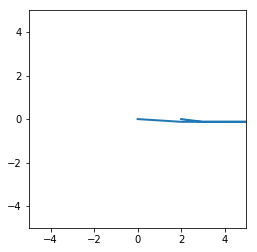

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()

ax.set_xlim(( -5, 5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')

line, = ax.plot([], [], lw=2)

last_q = q

def init():
    line.set_data([], [])
    return (line,)

def animate(i,q,meca):
    global last_q
    q = last_q
    # i: contador de iteracion: hay que mapearla a un ángulo de la manivela
    omega=2*3.14159/100  # vel. angular
    q[6] = i*omega
    q[7] = 2*i*omega
    
    #llamar problema de pos:    
    q = resuelve_prob_posicion(q, meca)
    last_q = q
     
    #Extraer las coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]
       
    x=[meca["XA"], X1, X2, X3, meca["XB"]]
    y=[meca["YA"], Y1, Y2, Y3, meca["YB"]]
    
    
    line.set_data(x, y)
    return (line,)


anim = animation.FuncAnimation(fig, animate, init_func=init, fargs=(q,meca),
                               frames=100, interval=20, 
                               blit=True)

HTML(anim.to_html5_video())

q
array([[ 2.00000000e+00],
       [-5.15962048e-29],
       [ 5.00000000e+00],
       [ 4.20294993e-24],
       [ 3.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])


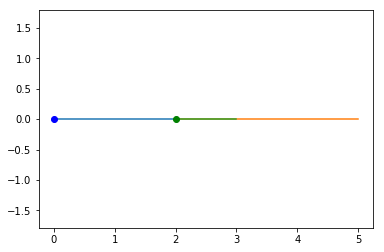

q
array([[ 1.99238941],
       [ 0.17431134],
       [ 4.981145  ],
       [-0.08518818],
       [ 2.9961947 ],
       [ 0.08715567],
       [ 0.08726639],
       [ 0.08726639]])


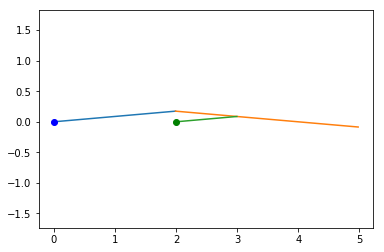

q
array([[ 1.96961556],
       [ 0.34729606],
       [ 4.92666884],
       [-0.15850616],
       [ 2.98480778],
       [ 0.17364803],
       [ 0.17453278],
       [ 0.17453278]])


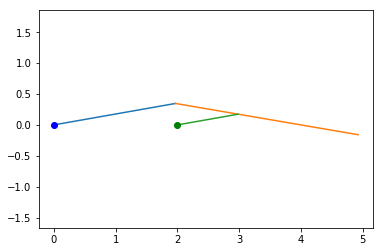

q
array([[ 1.93185177],
       [ 0.51763766],
       [ 4.8420803 ],
       [-0.21076462],
       [ 2.96592588],
       [ 0.25881883],
       [ 0.26179917],
       [ 0.26179917]])


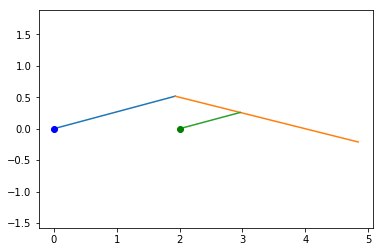

q
array([[ 1.87938544],
       [ 0.68403973],
       [ 4.73452289],
       [-0.23693266],
       [ 2.93969272],
       [ 0.34201987],
       [ 0.34906556],
       [ 0.34906556]])


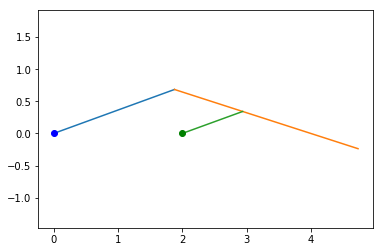

q
array([[ 1.81261589],
       [ 0.84523586],
       [ 4.6109629 ],
       [-0.23608462],
       [ 2.90630794],
       [ 0.42261793],
       [ 0.43633194],
       [ 0.43633194]])


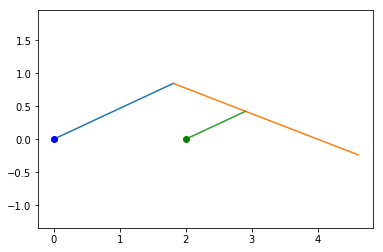

q
array([[ 1.73205125],
       [ 0.99999923],
       [ 4.47705776],
       [-0.21034752],
       [ 2.86602562],
       [ 0.49999962],
       [ 0.52359833],
       [ 0.52359833]])


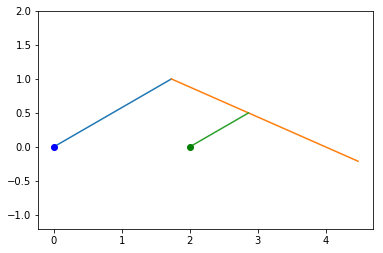

q
array([[ 1.63830468],
       [ 1.14715203],
       [ 4.3368099 ],
       [-0.1635995 ],
       [ 2.81915234],
       [ 0.57357601],
       [ 0.61086472],
       [ 0.61086472]])


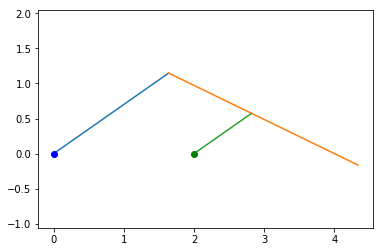

q
array([[ 1.53208964],
       [ 1.28557432],
       [ 4.19274164],
       [-0.10040223],
       [ 2.76604482],
       [ 0.64278716],
       [ 0.69813111],
       [ 0.69813111]])


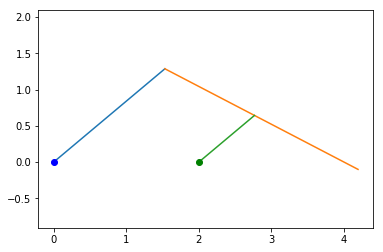

q
array([[ 1.4142145 ],
       [ 1.41421262],
       [ 4.04628028],
       [-0.02531152],
       [ 2.70710725],
       [ 0.70710631],
       [ 0.7853975 ],
       [ 0.7853975 ]])


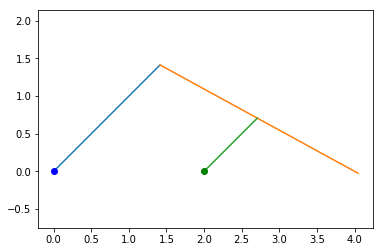

q
array([[1.28557635],
       [1.53208794],
       [3.89815145],
       [0.05748584],
       [2.64278817],
       [0.76604397],
       [0.87266389],
       [0.87266389]])


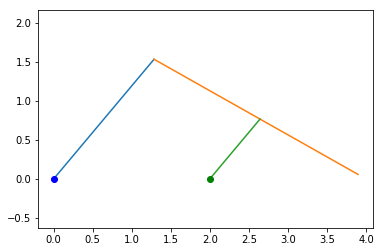

q
array([[1.1471542 ],
       [1.63830316],
       [3.74869362],
       [0.14431766],
       [2.5735771 ],
       [0.81915158],
       [0.95993028],
       [0.95993028]])


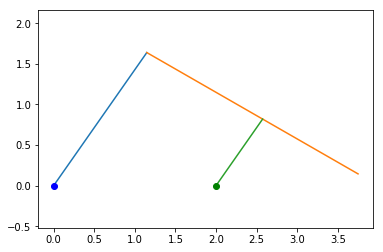

q
array([[1.00000153],
       [1.73204992],
       [3.59807774],
       [0.23204992],
       [2.50000077],
       [0.86602496],
       [1.04719667],
       [1.04719667]])


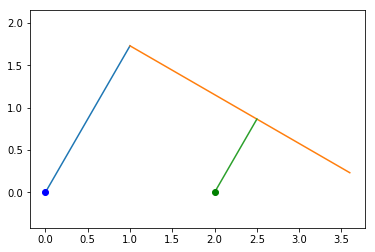

q
array([[0.84523826],
       [1.81261476],
       [3.44644632],
       [0.31805241],
       [2.42261913],
       [0.90630738],
       [1.13446306],
       [1.13446306]])


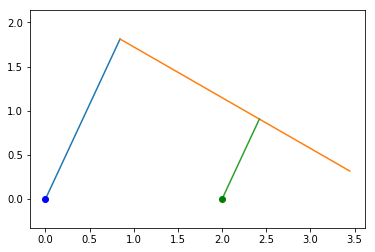

q
array([[0.68404223],
       [1.87938454],
       [3.29399338],
       [0.40014319],
       [2.34202111],
       [0.93969227],
       [1.22172944],
       [1.22172944]])


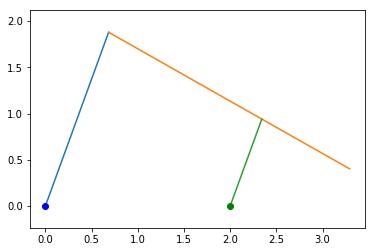

q
array([[0.51764023],
       [1.93185108],
       [3.14100487],
       [0.47653051],
       [2.25882011],
       [0.96592554],
       [1.30899583],
       [1.30899583]])


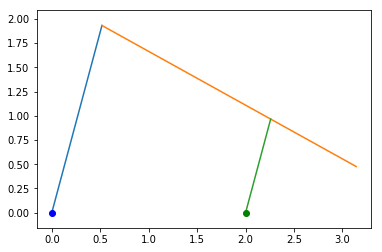

q
array([[0.34729868],
       [1.9696151 ],
       [2.98787384],
       [0.54576019],
       [2.17364934],
       [0.98480755],
       [1.39626222],
       [1.39626222]])


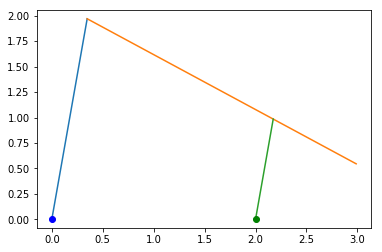

q
array([[0.17431398],
       [1.99238918],
       [2.83510058],
       [0.60667106],
       [2.08715699],
       [0.99619459],
       [1.48352861],
       [1.48352861]])


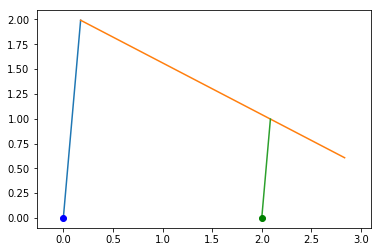

q
array([[2.65358979e-06],
       [2.00000000e+00],
       [2.68328387e+00],
       [6.58358501e-01],
       [2.00000133e+00],
       [1.00000000e+00],
       [1.57079500e+00],
       [1.57079500e+00]])


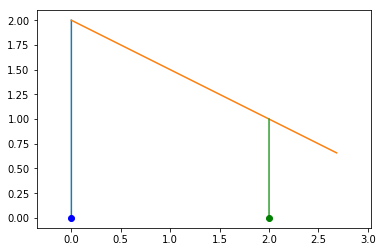

q
array([[-0.1743087 ],
       [ 1.99238964],
       [ 2.53310771],
       [ 0.70014492],
       [ 1.91284565],
       [ 0.99619482],
       [ 1.65806139],
       [ 1.65806139]])


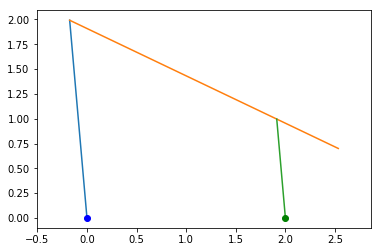

q
array([[-0.34729345],
       [ 1.96961602],
       [ 2.38532567],
       [ 0.73155596],
       [ 1.82635327],
       [ 0.98480801],
       [ 1.74532778],
       [ 1.74532778]])


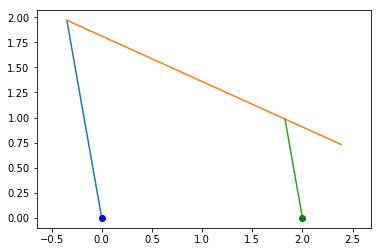

q
array([[-0.5176351 ],
       [ 1.93185245],
       [ 2.24074461],
       [ 0.7523011 ],
       [ 1.74118245],
       [ 0.96592623],
       [ 1.83259417],
       [ 1.83259417]])


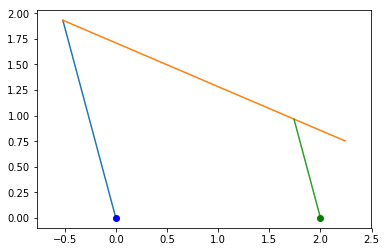

q
array([[-0.68403724],
       [ 1.87938635],
       [ 2.10020829],
       [ 0.76225752],
       [ 1.65798138],
       [ 0.93969318],
       [ 1.91986056],
       [ 1.91986056]])


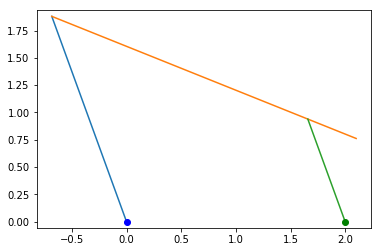

q
array([[-0.84523345],
       [ 1.81261701],
       [ 1.96458172],
       [ 0.76145635],
       [ 1.57738327],
       [ 0.9063085 ],
       [ 2.00712694],
       [ 2.00712694]])


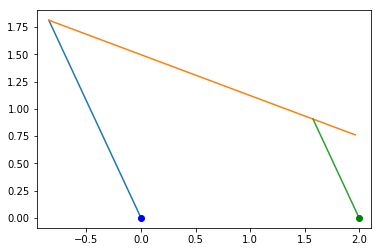

q
array([[-0.99999694],
       [ 1.73205258],
       [ 1.83473612],
       [ 0.75007064],
       [ 1.50000153],
       [ 0.86602629],
       [ 2.09439333],
       [ 2.09439333]])


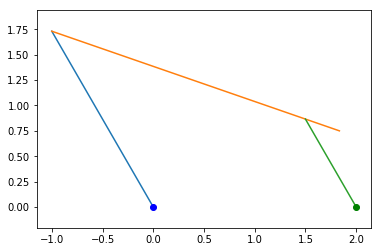

q
array([[-1.14714985],
       [ 1.6383062 ],
       [ 1.71153493],
       [ 0.72840438],
       [ 1.42642507],
       [ 0.8191531 ],
       [ 2.18165972],
       [ 2.18165972]])


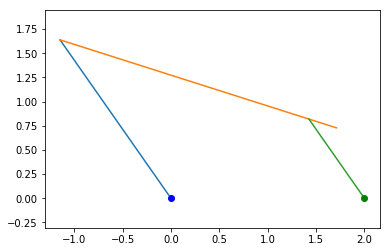

q
array([[-1.28557228],
       [ 1.53209135],
       [ 1.59582078],
       [ 0.69688238],
       [ 1.35721386],
       [ 0.76604568],
       [ 2.26892611],
       [ 2.26892611]])


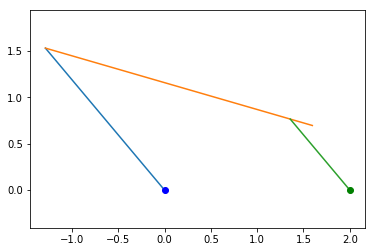

q
array([[-1.41421075],
       [ 1.41421638],
       [ 1.48840345],
       [ 0.6560404 ],
       [ 1.29289463],
       [ 0.70710819],
       [ 2.3561925 ],
       [ 2.3561925 ]])


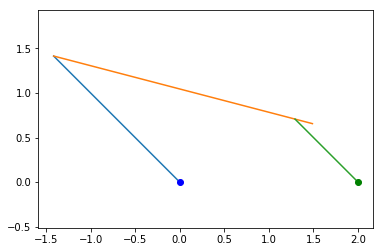

q
array([[-1.53208623],
       [ 1.28557838],
       [ 1.3900489 ],
       [ 0.60651562],
       [ 1.23395688],
       [ 0.64278919],
       [ 2.44345889],
       [ 2.44345889]])


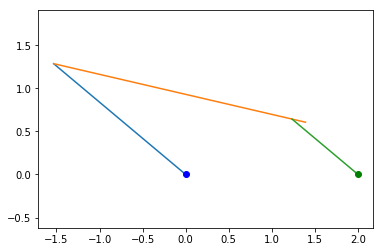

q
array([[-1.63830164],
       [ 1.14715637],
       [ 1.30146933],
       [ 0.54903708],
       [ 1.18084918],
       [ 0.57357819],
       [ 2.53072528],
       [ 2.53072528]])


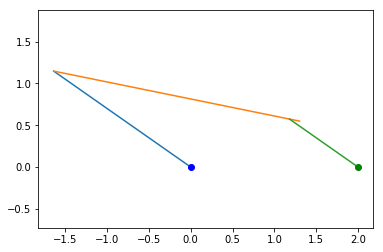

q
array([[-1.7320486 ],
       [ 1.00000383],
       [ 1.2233142 ],
       [ 0.48441607],
       [ 1.1339757 ],
       [ 0.50000192],
       [ 2.61799167],
       [ 2.61799167]])


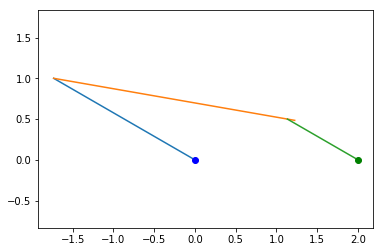

q
array([[-1.81261364],
       [ 0.84524067],
       [ 1.15616244],
       [ 0.41353637],
       [ 1.09369318],
       [ 0.42262033],
       [ 2.70525806],
       [ 2.70525806]])


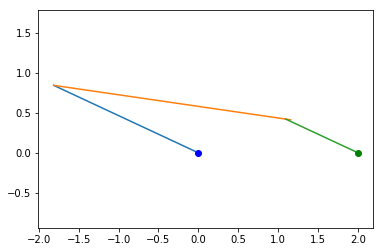

q
array([[-1.87938363],
       [ 0.68404472],
       [ 1.10051551],
       [ 0.33734439],
       [ 1.06030819],
       [ 0.34202236],
       [ 2.79252444],
       [ 2.79252444]])


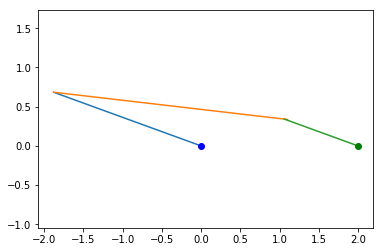

q
array([[-1.93185039],
       [ 0.51764279],
       [ 1.05679167],
       [ 0.25683901],
       [ 1.0340748 ],
       [ 0.25882139],
       [ 2.87979083],
       [ 2.87979083]])


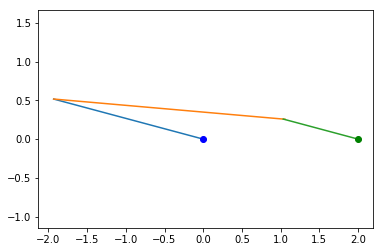

q
array([[-1.96961464],
       [ 0.34730129],
       [ 1.02532117],
       [ 0.17306139],
       [ 1.01519268],
       [ 0.17365065],
       [ 2.96705722],
       [ 2.96705722]])


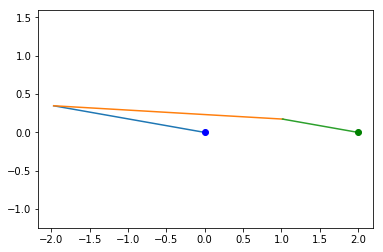

q
array([[-1.99238895],
       [ 0.17431663],
       [ 1.00634255],
       [ 0.08708451],
       [ 1.00380553],
       [ 0.08715831],
       [ 3.05432361],
       [ 3.05432361]])


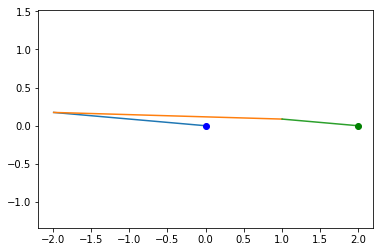

q
array([[-2.00000000e+00],
       [ 5.30717959e-06],
       [ 1.00000000e+00],
       [ 2.65358979e-06],
       [ 1.00000000e+00],
       [ 2.65358979e-06],
       [ 3.14159000e+00],
       [ 3.14159000e+00]])


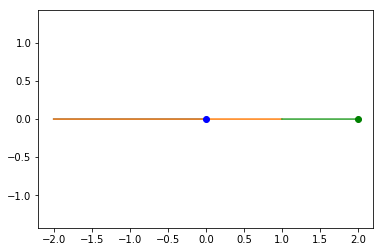

q
array([[-1.99238987],
       [-0.17430605],
       [ 1.00634177],
       [-0.08707924],
       [ 1.00380506],
       [-0.08715303],
       [ 3.22885639],
       [ 3.22885639]])


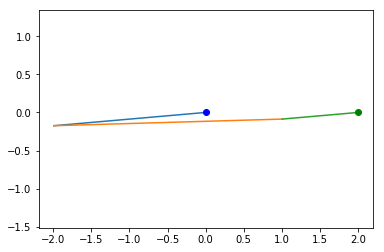

q
array([[-1.96961648],
       [-0.34729084],
       [ 1.02531963],
       [-0.17305622],
       [ 1.01519176],
       [-0.17364542],
       [ 3.31612278],
       [ 3.31612278]])


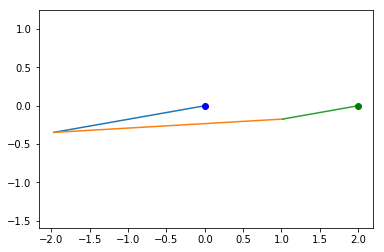

q
array([[-1.93185314],
       [-0.51763254],
       [ 1.05678938],
       [-0.256834  ],
       [ 1.03407343],
       [-0.25881627],
       [ 3.40338917],
       [ 3.40338917]])


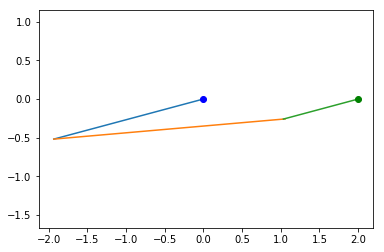

q
array([[-1.87938726],
       [-0.68403475],
       [ 1.10051249],
       [-0.33733961],
       [ 1.06030637],
       [-0.34201737],
       [ 3.49065556],
       [ 3.49065556]])


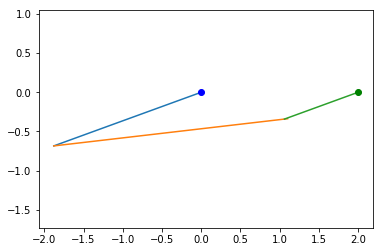

q
array([[-1.81261813],
       [-0.84523105],
       [ 1.1561587 ],
       [-0.41353189],
       [ 1.09369094],
       [-0.42261552],
       [ 3.57792194],
       [ 3.57792194]])


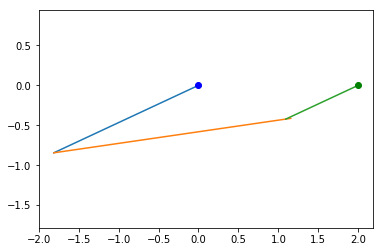

q
array([[-1.7320539 ],
       [-0.99999464],
       [ 1.22330978],
       [-0.48441194],
       [ 1.13397305],
       [-0.49999732],
       [ 3.66518833],
       [ 3.66518833]])


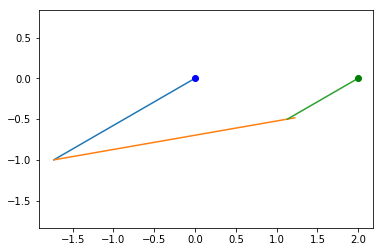

q
array([[-1.63830772],
       [-1.14714768],
       [ 1.30146425],
       [-0.54903336],
       [ 1.18084614],
       [-0.57357384],
       [ 3.75245472],
       [ 3.75245472]])


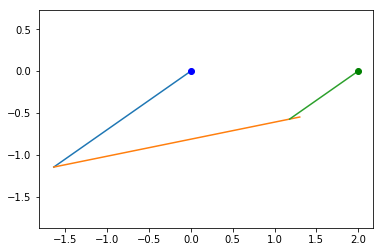

q
array([[-1.53209306],
       [-1.28557025],
       [ 1.39004321],
       [-0.60651236],
       [ 1.23395347],
       [-0.64278513],
       [ 3.83972111],
       [ 3.83972111]])


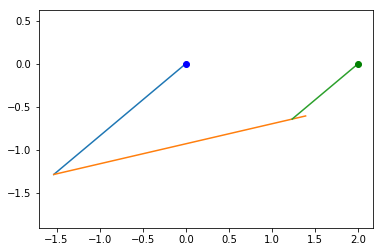

q
array([[-1.41421825],
       [-1.41420887],
       [ 1.48839719],
       [-0.65603764],
       [ 1.29289087],
       [-0.70710444],
       [ 3.9269875 ],
       [ 3.9269875 ]])


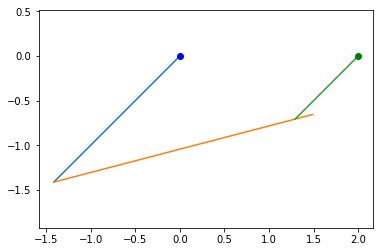

q
array([[-1.28558041],
       [-1.53208453],
       [ 1.59581399],
       [-0.69688017],
       [ 1.35720979],
       [-0.76604226],
       [ 4.01425389],
       [ 4.01425389]])


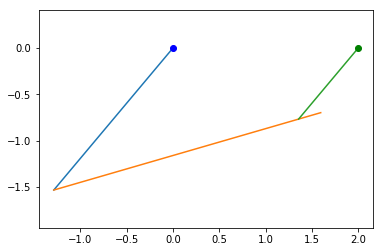

q
array([[-1.14715855],
       [-1.63830011],
       [ 1.71152765],
       [-0.72840276],
       [ 1.42642073],
       [-0.81915006],
       [ 4.10152028],
       [ 4.10152028]])


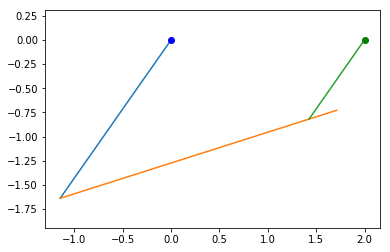

q
array([[-1.00000613],
       [-1.73204727],
       [ 1.83472841],
       [-0.75006963],
       [ 1.49999694],
       [-0.86602363],
       [ 4.18878667],
       [ 4.18878667]])


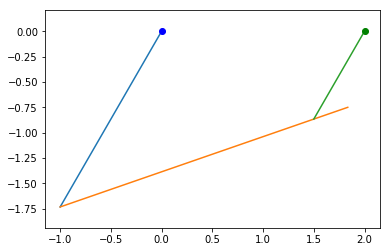

q
array([[-0.84524307],
       [-1.81261252],
       [ 1.96457364],
       [-0.76145598],
       [ 1.57737846],
       [-0.90630626],
       [ 4.27605306],
       [ 4.27605306]])


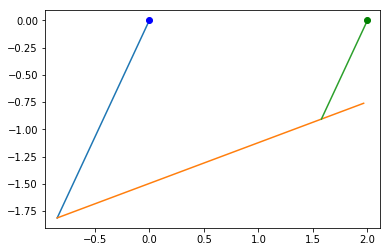

q
array([[-0.68404721],
       [-1.87938272],
       [ 2.10019989],
       [-0.7622578 ],
       [ 1.65797639],
       [-0.93969136],
       [ 4.36331944],
       [ 4.36331944]])


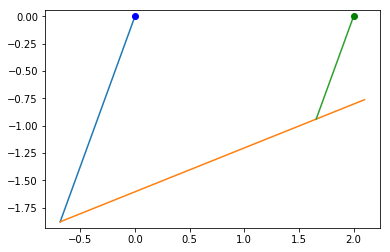

q
array([[-0.51764535],
       [-1.93184971],
       [ 2.24073593],
       [-0.75230203],
       [ 1.74117732],
       [-0.96592485],
       [ 4.45058583],
       [ 4.45058583]])


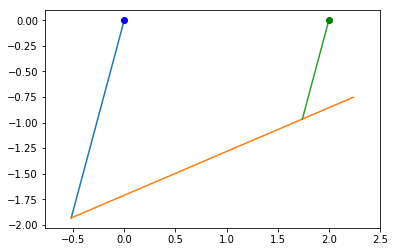

q
array([[-0.3473039 ],
       [-1.96961417],
       [ 2.38531677],
       [-0.73155754],
       [ 1.82634805],
       [-0.98480709],
       [ 4.53785222],
       [ 4.53785222]])


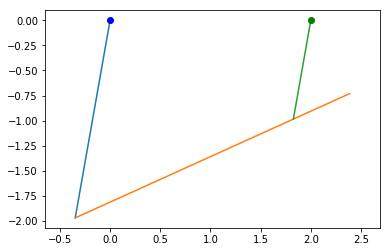

q
array([[-0.17431927],
       [-1.99238872],
       [ 2.53309864],
       [-0.70014715],
       [ 1.91284037],
       [-0.99619436],
       [ 4.62511861],
       [ 4.62511861]])


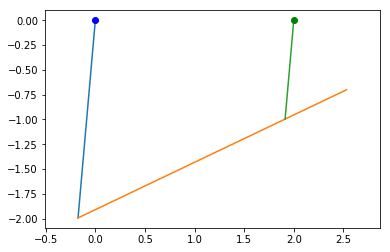

q
array([[-7.96076938e-06],
       [-2.00000000e+00],
       [ 2.68327468e+00],
       [-6.58361350e-01],
       [ 1.99999602e+00],
       [-1.00000000e+00],
       [ 4.71238500e+00],
       [ 4.71238500e+00]])


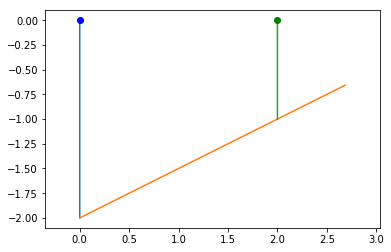

q
array([[ 0.17430341],
       [-1.9923901 ],
       [ 2.83509131],
       [-0.60667449],
       [ 2.0871517 ],
       [-0.99619505],
       [ 4.79965139],
       [ 4.79965139]])


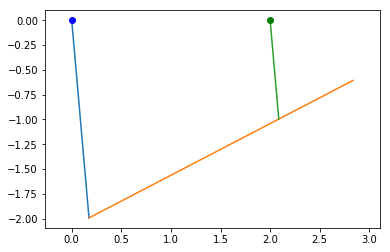

q
array([[ 0.34728823],
       [-1.96961694],
       [ 2.98786454],
       [-0.54576416],
       [ 2.17364411],
       [-0.98480847],
       [ 4.88691778],
       [ 4.88691778]])


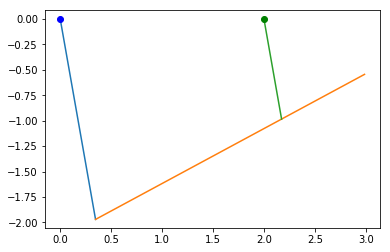

q
array([[ 0.51762997],
       [-1.93185383],
       [ 3.14099555],
       [-0.47653495],
       [ 2.25881499],
       [-0.96592691],
       [ 4.97418417],
       [ 4.97418417]])


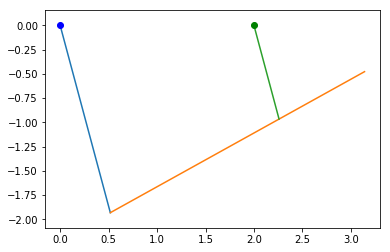

q
array([[ 0.68403225],
       [-1.87938817],
       [ 3.29398409],
       [-0.40014802],
       [ 2.34201613],
       [-0.93969408],
       [ 5.06145056],
       [ 5.06145056]])


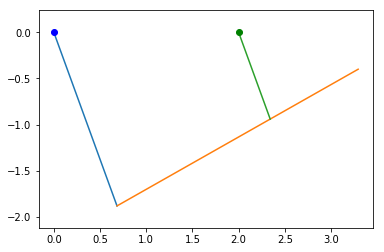

q
array([[ 0.84522864],
       [-1.81261925],
       [ 3.44643707],
       [-0.31805754],
       [ 2.42261432],
       [-0.90630962],
       [ 5.14871694],
       [ 5.14871694]])


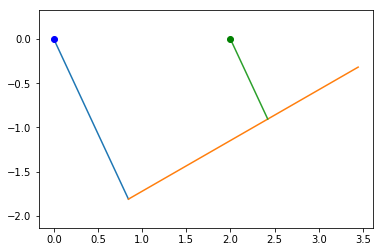

q
array([[ 0.99999234],
       [-1.73205523],
       [ 3.59806855],
       [-0.23205523],
       [ 2.49999617],
       [-0.86602762],
       [ 5.23598333],
       [ 5.23598333]])


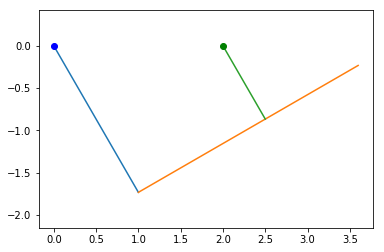

q
array([[ 1.14714551],
       [-1.63830925],
       [ 3.74868449],
       [-0.144323  ],
       [ 2.57357275],
       [-0.81915462],
       [ 5.32324972],
       [ 5.32324972]])


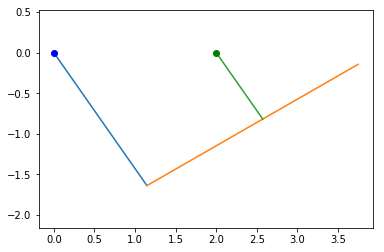

q
array([[ 1.28556822],
       [-1.53209476],
       [ 3.8981424 ],
       [-0.05749104],
       [ 2.64278411],
       [-0.76604738],
       [ 5.41051611],
       [ 5.41051611]])


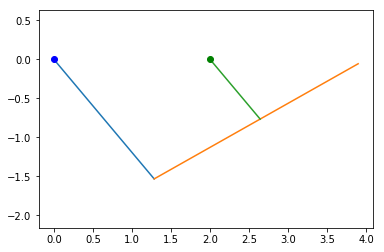

q
array([[ 1.414207  ],
       [-1.41422013],
       [ 4.04627131],
       [ 0.02530668],
       [ 2.7071035 ],
       [-0.70711006],
       [ 5.4977825 ],
       [ 5.4977825 ]])


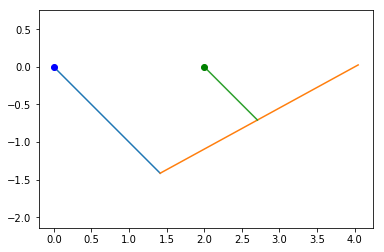

q
array([[ 1.53208282],
       [-1.28558245],
       [ 4.19273279],
       [ 0.10039798],
       [ 2.76604141],
       [-0.64279122],
       [ 5.58504889],
       [ 5.58504889]])


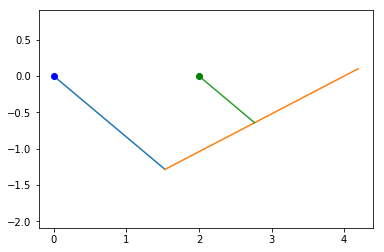

q
array([[ 1.63829859],
       [-1.14716072],
       [ 4.33680124],
       [ 0.16359611],
       [ 2.8191493 ],
       [-0.57358036],
       [ 5.67231528],
       [ 5.67231528]])


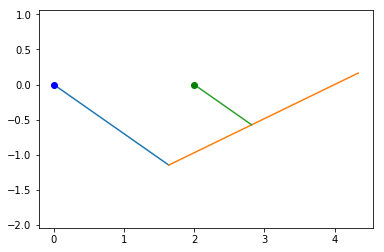

q
array([[ 1.73204594],
       [-1.00000843],
       [ 4.47704939],
       [ 0.21034527],
       [ 2.86602297],
       [-0.50000421],
       [ 5.75958167],
       [ 5.75958167]])


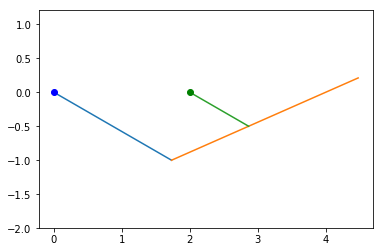

q
array([[ 1.8126114 ],
       [-0.84524548],
       [ 4.61095502],
       [ 0.23608378],
       [ 2.9063057 ],
       [-0.42262274],
       [ 5.84684806],
       [ 5.84684806]])


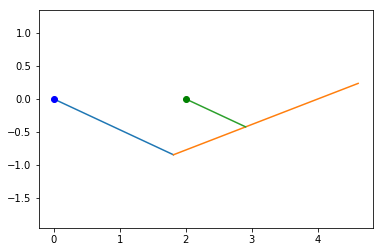

q
array([[ 1.87938181],
       [-0.68404971],
       [ 4.7345158 ],
       [ 0.23693342],
       [ 2.93969091],
       [-0.34202485],
       [ 5.93411444],
       [ 5.93411444]])


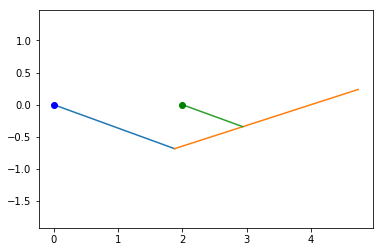

q
array([[ 1.93184902],
       [-0.51764792],
       [ 4.84207438],
       [ 0.21076703],
       [ 2.96592451],
       [-0.25882396],
       [ 6.02138083],
       [ 6.02138083]])


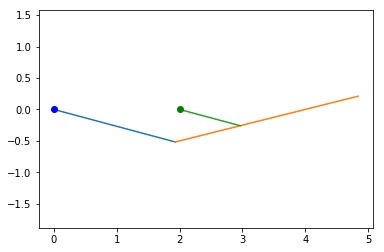

q
array([[ 1.96961371],
       [-0.34730652],
       [ 4.92666454],
       [ 0.15851005],
       [ 2.98480686],
       [-0.17365326],
       [ 6.10864722],
       [ 6.10864722]])


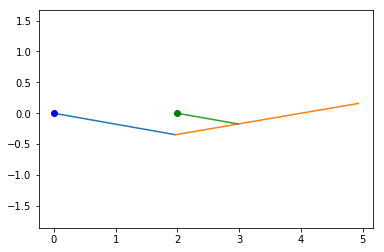

q
array([[ 1.99238848],
       [-0.17432191],
       [ 4.98114273],
       [ 0.08519311],
       [ 2.99619424],
       [-0.08716096],
       [ 6.19591361],
       [ 6.19591361]])


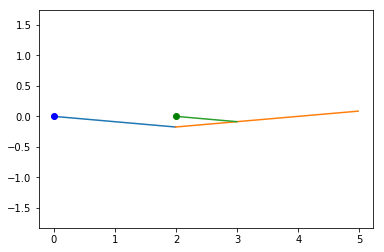

q
array([[ 2.00000000e+00],
       [-1.06143592e-05],
       [ 5.00000000e+00],
       [ 5.30717959e-06],
       [ 3.00000000e+00],
       [-5.30717959e-06],
       [ 6.28318000e+00],
       [ 6.28318000e+00]])


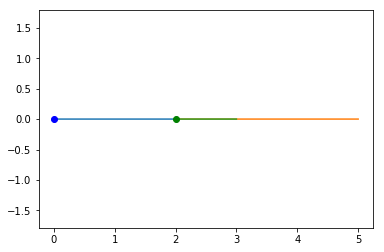

q
array([[ 1.99239033],
       [ 0.17430076],
       [ 4.98114727],
       [-0.08518325],
       [ 2.99619517],
       [ 0.08715038],
       [ 6.37044639],
       [ 6.37044639]])


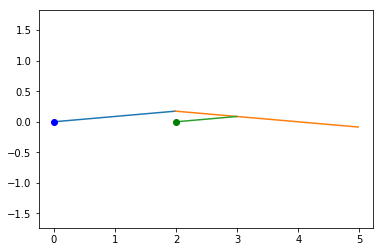

q
array([[ 1.9696174 ],
       [ 0.34728561],
       [ 4.92667314],
       [-0.15850227],
       [ 2.9848087 ],
       [ 0.17364281],
       [ 6.45771278],
       [ 6.45771278]])


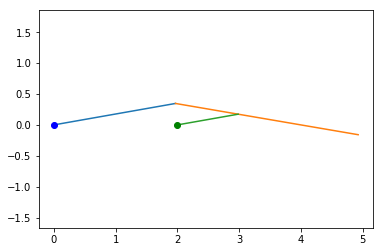

q
array([[ 1.93185451],
       [ 0.51762741],
       [ 4.84208622],
       [-0.21076221],
       [ 2.96592726],
       [ 0.25881371],
       [ 6.54497917],
       [ 6.54497917]])


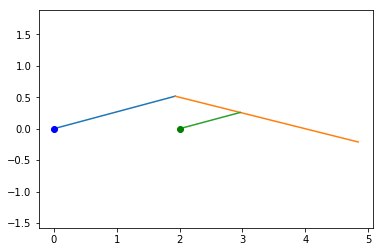

q
array([[ 1.87938907],
       [ 0.68402976],
       [ 4.73452999],
       [-0.2369319 ],
       [ 2.93969454],
       [ 0.34201488],
       [ 6.63224556],
       [ 6.63224556]])


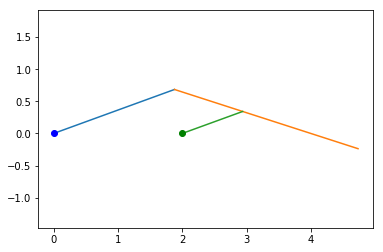

q
array([[ 1.81262037],
       [ 0.84522624],
       [ 4.61097078],
       [-0.23608546],
       [ 2.90631019],
       [ 0.42261312],
       [ 6.71951194],
       [ 6.71951194]])


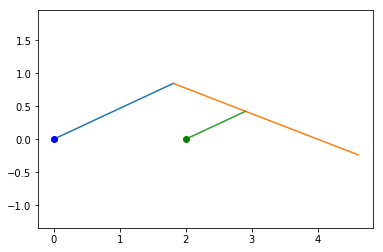

q
array([[ 1.73205656],
       [ 0.99999004],
       [ 4.47706613],
       [-0.21034977],
       [ 2.86602828],
       [ 0.49999502],
       [ 6.80677833],
       [ 6.80677833]])


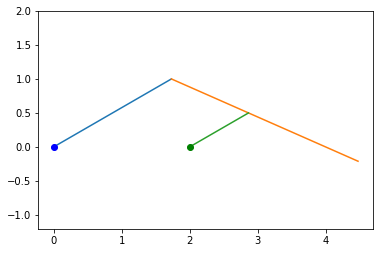

q
array([[ 1.63831077],
       [ 1.14714333],
       [ 4.33681857],
       [-0.16360289],
       [ 2.81915538],
       [ 0.57357167],
       [ 6.89404472],
       [ 6.89404472]])


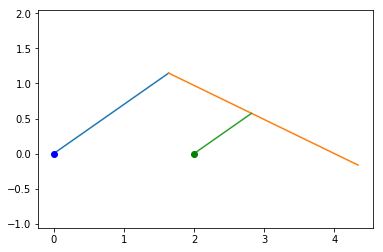

q
array([[ 1.53209647],
       [ 1.28556618],
       [ 4.19275048],
       [-0.10040648],
       [ 2.76604823],
       [ 0.64278309],
       [ 6.98131111],
       [ 6.98131111]])


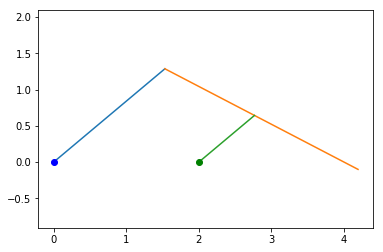

q
array([[ 1.41422201],
       [ 1.41420512],
       [ 4.04628924],
       [-0.02531636],
       [ 2.707111  ],
       [ 0.70710256],
       [ 7.0685775 ],
       [ 7.0685775 ]])


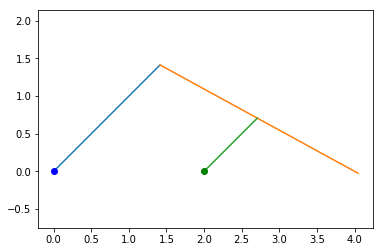

q
array([[1.28558448],
       [1.53208112],
       [3.8981605 ],
       [0.05748065],
       [2.64279224],
       [0.76604056],
       [7.15584389],
       [7.15584389]])


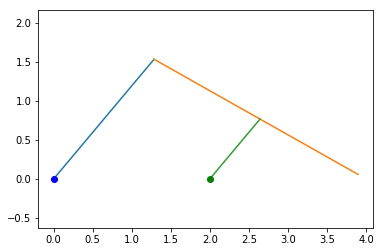

q
array([[1.1471629 ],
       [1.63829707],
       [3.74870274],
       [0.14431233],
       [2.57358145],
       [0.81914854],
       [7.24311028],
       [7.24311028]])


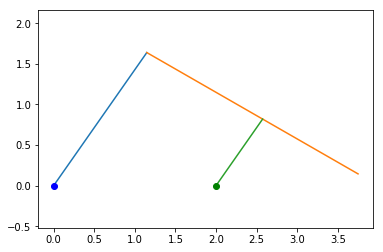

q
array([[1.00001072],
       [1.73204462],
       [3.59808694],
       [0.23204462],
       [2.50000536],
       [0.86602231],
       [7.33037667],
       [7.33037667]])


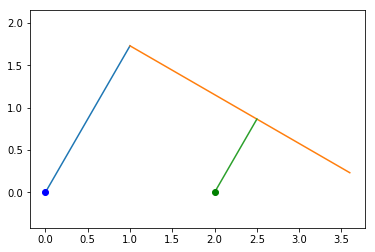

q
array([[0.84524788],
       [1.81261028],
       [3.44645557],
       [0.31804728],
       [2.42262394],
       [0.90630514],
       [7.41764306],
       [7.41764306]])


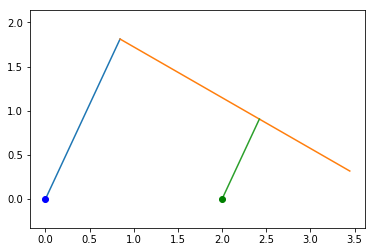

q
array([[0.6840522 ],
       [1.87938091],
       [3.29400267],
       [0.40013835],
       [2.3420261 ],
       [0.93969045],
       [7.50490944],
       [7.50490944]])


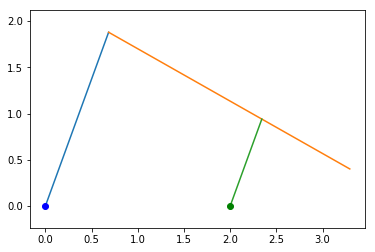

q
array([[0.51765048],
       [1.93184833],
       [3.14101418],
       [0.47652607],
       [2.25882524],
       [0.96592417],
       [7.59217583],
       [7.59217583]])


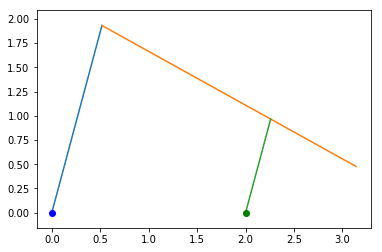

q
array([[0.34730913],
       [1.96961325],
       [2.98788315],
       [0.54575622],
       [2.17365457],
       [0.98480663],
       [7.67944222],
       [7.67944222]])


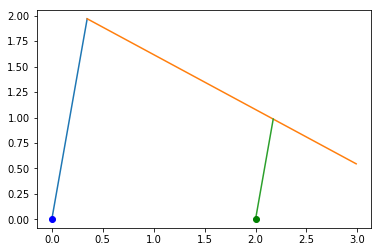

q
array([[0.17432456],
       [1.99238825],
       [2.83510985],
       [0.60666763],
       [2.08716228],
       [0.99619413],
       [7.76670861],
       [7.76670861]])


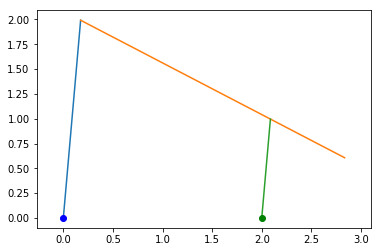

q
array([[1.32679490e-05],
       [2.00000000e+00],
       [2.68329306e+00],
       [6.58355653e-01],
       [2.00000663e+00],
       [1.00000000e+00],
       [7.85397500e+00],
       [7.85397500e+00]])


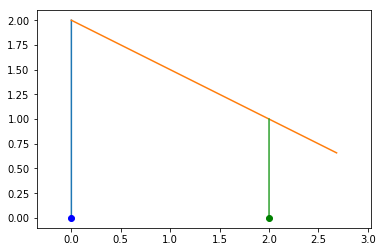

q
array([[-0.17429812],
       [ 1.99239057],
       [ 2.53311677],
       [ 0.70014269],
       [ 1.91285094],
       [ 0.99619528],
       [ 7.94124139],
       [ 7.94124139]])


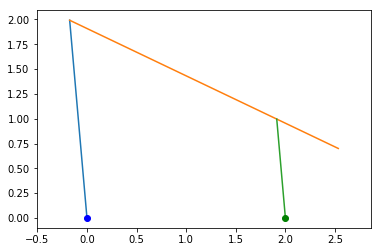

q
array([[-0.347283  ],
       [ 1.96961786],
       [ 2.38533457],
       [ 0.73155437],
       [ 1.8263585 ],
       [ 0.98480893],
       [ 8.02850778],
       [ 8.02850778]])


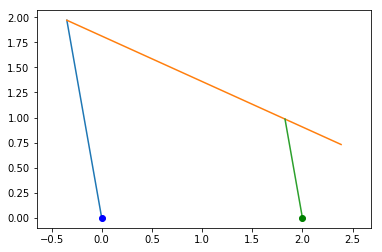

q
array([[-0.51762485],
       [ 1.9318552 ],
       [ 2.24075328],
       [ 0.75230016],
       [ 1.74118758],
       [ 0.9659276 ],
       [ 8.11577417],
       [ 8.11577417]])


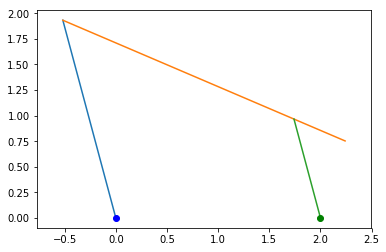

q
array([[-0.68402726],
       [ 1.87938998],
       [ 2.1002167 ],
       [ 0.76225724],
       [ 1.65798637],
       [ 0.93969499],
       [ 8.20304056],
       [ 8.20304056]])


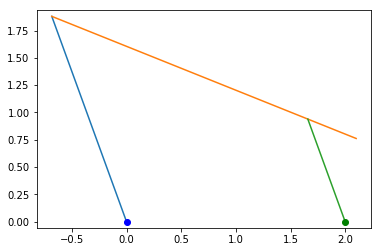

q
array([[-0.84522383],
       [ 1.81262149],
       [ 1.9645898 ],
       [ 0.76145673],
       [ 1.57738808],
       [ 0.90631075],
       [ 8.29030694],
       [ 8.29030694]])


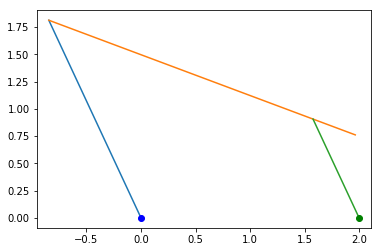

q
array([[-0.99998774],
       [ 1.73205788],
       [ 1.83474382],
       [ 0.75007165],
       [ 1.50000613],
       [ 0.86602894],
       [ 8.37757333],
       [ 8.37757333]])


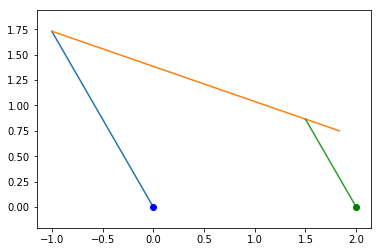

q
array([[-1.14714116],
       [ 1.63831229],
       [ 1.7115422 ],
       [ 0.72840601],
       [ 1.42642942],
       [ 0.81915615],
       [ 8.46483972],
       [ 8.46483972]])


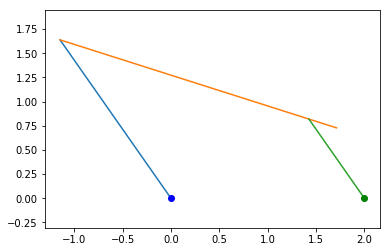

q
array([[-1.28556415],
       [ 1.53209817],
       [ 1.59582757],
       [ 0.69688459],
       [ 1.35721792],
       [ 0.76604909],
       [ 8.55210611],
       [ 8.55210611]])


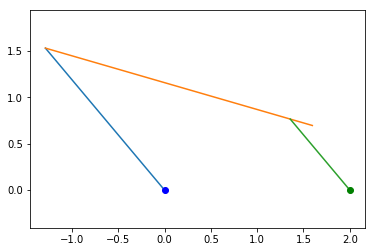

q
array([[-1.41420324],
       [ 1.41422388],
       [ 1.48840972],
       [ 0.65604315],
       [ 1.29289838],
       [ 0.70711194],
       [ 8.6393725 ],
       [ 8.6393725 ]])


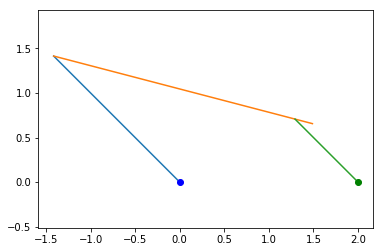

q
array([[-1.53207941],
       [ 1.28558651],
       [ 1.3900546 ],
       [ 0.60651888],
       [ 1.23396029],
       [ 0.64279326],
       [ 8.72663889],
       [ 8.72663889]])


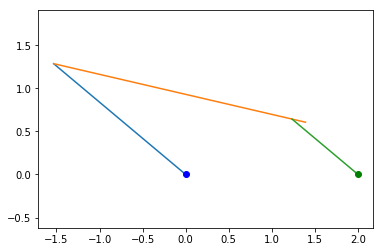

q
array([[-1.63829555],
       [ 1.14716507],
       [ 1.3014744 ],
       [ 0.5490408 ],
       [ 1.18085223],
       [ 0.57358253],
       [ 8.81390528],
       [ 8.81390528]])


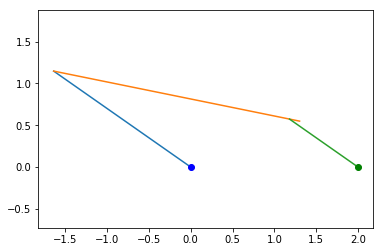

q
array([[-1.73204329],
       [ 1.00001302],
       [ 1.22331862],
       [ 0.4844202 ],
       [ 1.13397836],
       [ 0.50000651],
       [ 8.90117167],
       [ 8.90117167]])


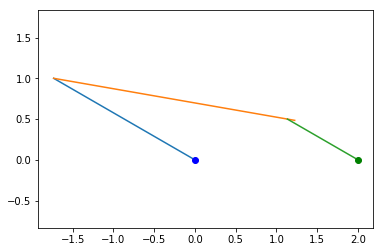

q
array([[-1.81260916],
       [ 0.84525029],
       [ 1.15616617],
       [ 0.41354085],
       [ 1.09369542],
       [ 0.42262514],
       [ 8.98843806],
       [ 8.98843806]])


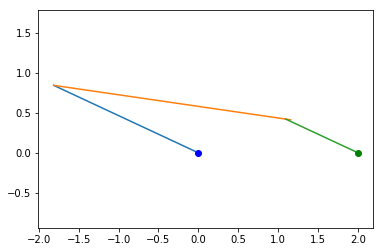

q
array([[-1.87938   ],
       [ 0.68405469],
       [ 1.10051854],
       [ 0.33734916],
       [ 1.06031   ],
       [ 0.34202735],
       [ 9.07570444],
       [ 9.07570444]])


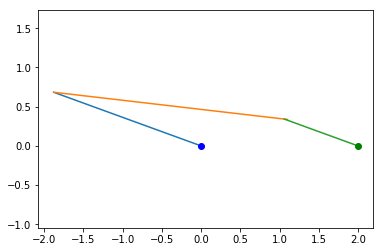

q
array([[-1.93184765],
       [ 0.51765304],
       [ 1.05679396],
       [ 0.25684401],
       [ 1.03407618],
       [ 0.25882652],
       [ 9.16297083],
       [ 9.16297083]])


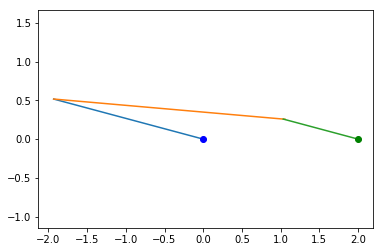

q
array([[-1.96961279],
       [ 0.34731174],
       [ 1.0253227 ],
       [ 0.17306656],
       [ 1.0151936 ],
       [ 0.17365587],
       [ 9.25023722],
       [ 9.25023722]])


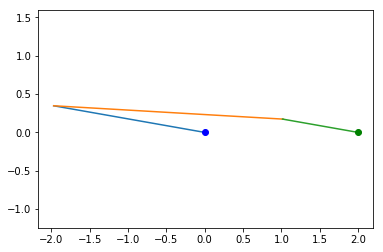

q
array([[-1.99238802],
       [ 0.1743272 ],
       [ 1.00634332],
       [ 0.08708979],
       [ 1.00380599],
       [ 0.0871636 ],
       [ 9.33750361],
       [ 9.33750361]])


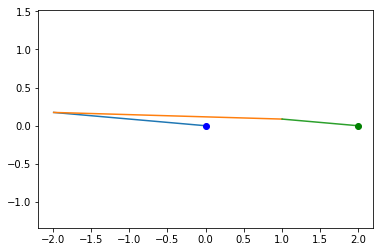

q
array([[-2.00000000e+00],
       [ 1.59215388e-05],
       [ 1.00000000e+00],
       [ 7.96076938e-06],
       [ 1.00000000e+00],
       [ 7.96076938e-06],
       [ 9.42477000e+00],
       [ 9.42477000e+00]])


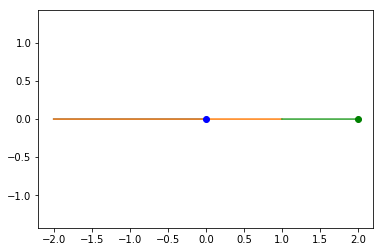

q
array([[-1.9923908 ],
       [-0.17429548],
       [ 1.006341  ],
       [-0.08707396],
       [ 1.0038046 ],
       [-0.08714774],
       [ 9.51203639],
       [ 9.51203639]])


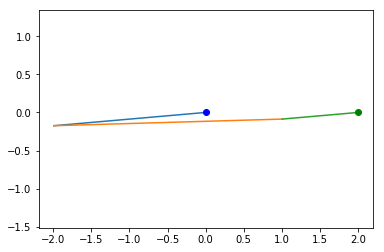

q
array([[-1.96961832],
       [-0.34728039],
       [ 1.02531809],
       [-0.17305104],
       [ 1.01519084],
       [-0.17364019],
       [ 9.59930278],
       [ 9.59930278]])


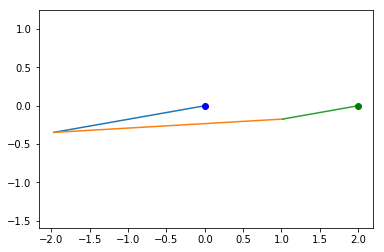

q
array([[-1.93185589],
       [-0.51762228],
       [ 1.05678709],
       [-0.256829  ],
       [ 1.03407206],
       [-0.25881114],
       [ 9.68656917],
       [ 9.68656917]])


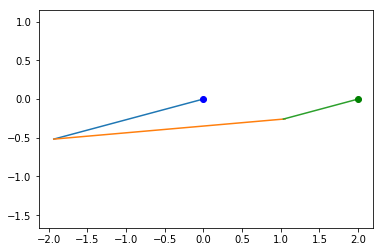

q
array([[-1.87939089],
       [-0.68402477],
       [ 1.10050946],
       [-0.33733483],
       [ 1.06030456],
       [-0.34201239],
       [ 9.77383556],
       [ 9.77383556]])


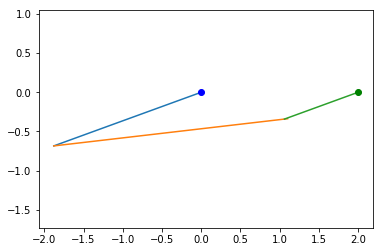

q
array([[-1.81262261],
       [-0.84522143],
       [ 1.15615496],
       [-0.41352741],
       [ 1.09368869],
       [-0.42261071],
       [ 9.86110194],
       [ 9.86110194]])


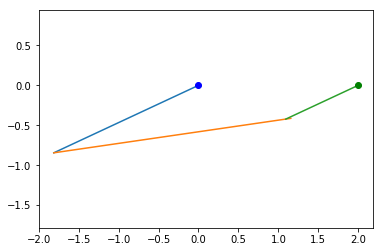

q
array([[-1.73205921],
       [-0.99998545],
       [ 1.22330535],
       [-0.48440781],
       [ 1.13397039],
       [-0.49999272],
       [ 9.94836833],
       [ 9.94836833]])


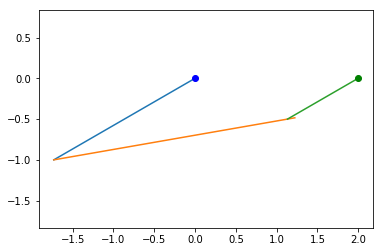

q
array([[-1.63831381],
       [-1.14713899],
       [ 1.30145917],
       [-0.54902964],
       [ 1.18084309],
       [-0.57356949],
       [10.03563472],
       [10.03563472]])


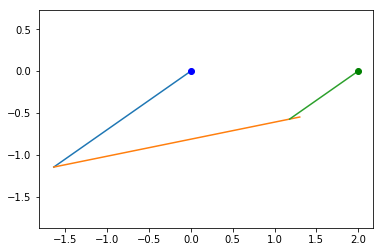

q
array([[-1.53209988],
       [-1.28556212],
       [ 1.39003752],
       [-0.6065091 ],
       [ 1.23395006],
       [-0.64278106],
       [10.12290111],
       [10.12290111]])


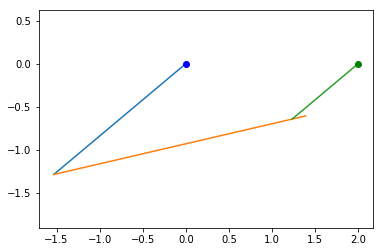

q
array([[-1.41422576],
       [-1.41420137],
       [ 1.48839092],
       [-0.65603489],
       [ 1.29288712],
       [-0.70710068],
       [10.2101675 ],
       [10.2101675 ]])


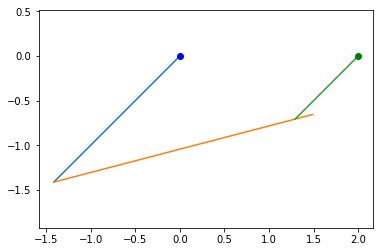

q
array([[-1.28558855],
       [-1.5320777 ],
       [ 1.59580719],
       [-0.69687797],
       [ 1.35720573],
       [-0.76603885],
       [10.29743389],
       [10.29743389]])


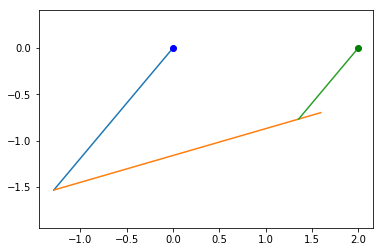

q
array([[-1.14716724],
       [-1.63829403],
       [ 1.71152038],
       [-0.72840114],
       [ 1.42641638],
       [-0.81914701],
       [10.38470028],
       [10.38470028]])


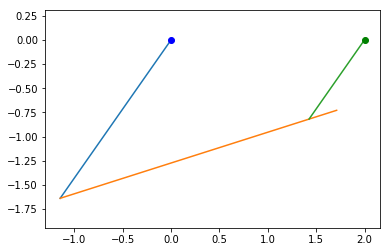

q
array([[-1.00001532],
       [-1.73204196],
       [ 1.83472071],
       [-0.75006862],
       [ 1.49999234],
       [-0.86602098],
       [10.47196667],
       [10.47196667]])


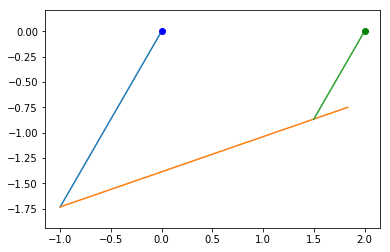

q
array([[-0.84525269],
       [-1.81260804],
       [ 1.96456556],
       [-0.76145561],
       [ 1.57737365],
       [-0.90630402],
       [10.55923306],
       [10.55923306]])


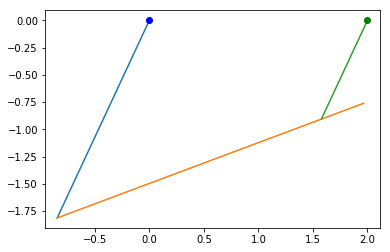

q
array([[-0.68405719],
       [-1.87937909],
       [ 2.10019148],
       [-0.76225807],
       [ 1.65797141],
       [-0.93968955],
       [10.64649944],
       [10.64649944]])


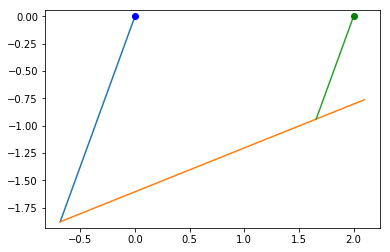

q
array([[-0.51765561],
       [-1.93184696],
       [ 2.24072725],
       [-0.75230297],
       [ 1.7411722 ],
       [-0.96592348],
       [10.73376583],
       [10.73376583]])


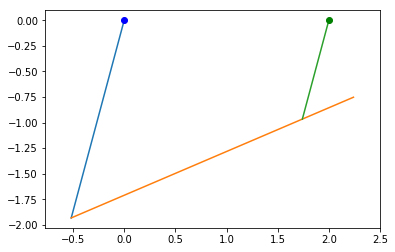

q
array([[-0.34731436],
       [-1.96961233],
       [ 2.38530788],
       [-0.73155913],
       [ 1.82634282],
       [-0.98480617],
       [10.82103222],
       [10.82103222]])


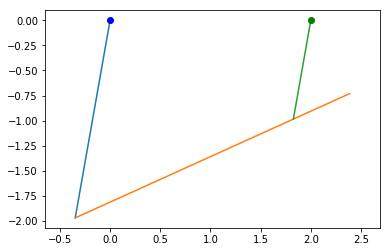

q
array([[-0.17432984],
       [-1.99238779],
       [ 2.53308957],
       [-0.70014937],
       [ 1.91283508],
       [-0.9961939 ],
       [10.90829861],
       [10.90829861]])


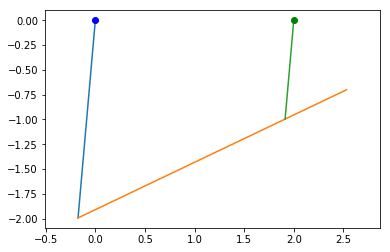

q
array([[-1.85751286e-05],
       [-2.00000000e+00],
       [ 2.68326549e+00],
       [-6.58364198e-01],
       [ 1.99999071e+00],
       [-1.00000000e+00],
       [ 1.09955650e+01],
       [ 1.09955650e+01]])


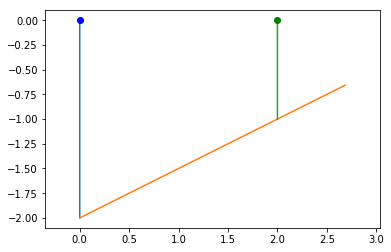

q
array([[ 0.17429283],
       [-1.99239103],
       [ 2.83508204],
       [-0.60667793],
       [ 2.08714642],
       [-0.99619551],
       [11.08283139],
       [11.08283139]])


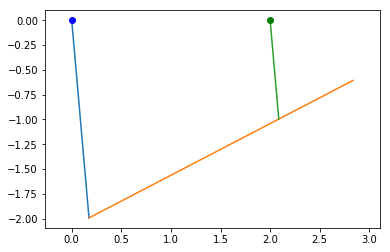

q
array([[ 0.34727777],
       [-1.96961878],
       [ 2.98785523],
       [-0.54576812],
       [ 2.17363889],
       [-0.98480939],
       [11.17009778],
       [11.17009778]])


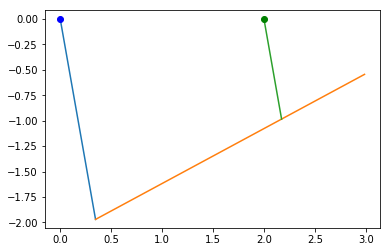

q
array([[ 0.51761972],
       [-1.93185657],
       [ 3.14098624],
       [-0.47653939],
       [ 2.25880986],
       [-0.96592829],
       [11.25736417],
       [11.25736417]])


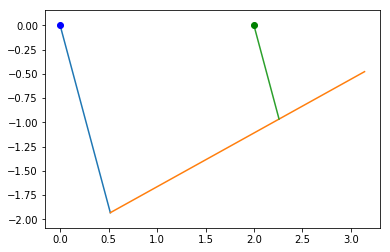

q
array([[ 0.68402228],
       [-1.8793918 ],
       [ 3.2939748 ],
       [-0.40015286],
       [ 2.34201114],
       [-0.9396959 ],
       [11.34463056],
       [11.34463056]])


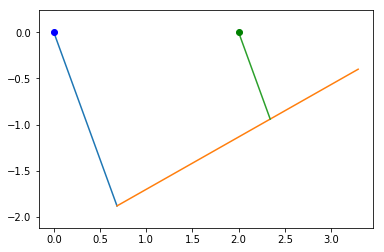

q
array([[ 0.84521902],
       [-1.81262374],
       [ 3.44642782],
       [-0.31806267],
       [ 2.42260951],
       [-0.90631187],
       [11.43189694],
       [11.43189694]])


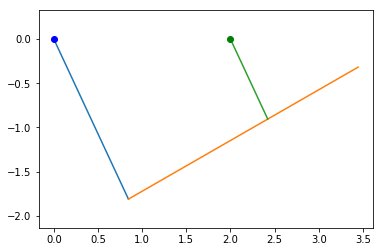

q
array([[ 0.99998315],
       [-1.73206054],
       [ 3.59805936],
       [-0.23206054],
       [ 2.49999157],
       [-0.86603027],
       [11.51916333],
       [11.51916333]])


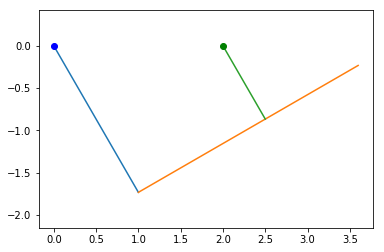

q
array([[ 1.14713681],
       [-1.63831533],
       [ 3.74867537],
       [-0.14432834],
       [ 2.57356841],
       [-0.81915767],
       [11.60642972],
       [11.60642972]])


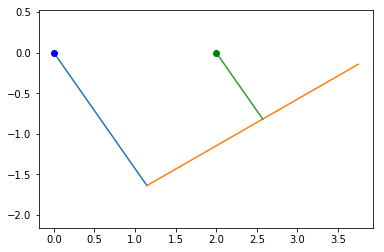

q
array([[ 1.28556009],
       [-1.53210158],
       [ 3.89813335],
       [-0.05749623],
       [ 2.64278004],
       [-0.76605079],
       [11.69369611],
       [11.69369611]])


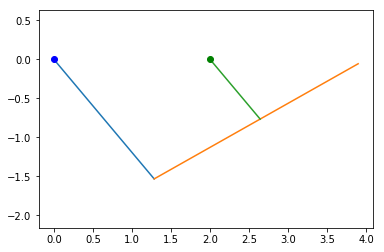

q
array([[ 1.41419949],
       [-1.41422764],
       [ 4.04626235],
       [ 0.02530183],
       [ 2.70709974],
       [-0.70711382],
       [11.7809625 ],
       [11.7809625 ]])


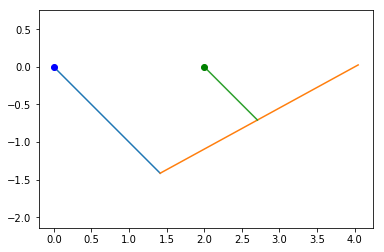

q
array([[ 1.532076  ],
       [-1.28559058],
       [ 4.19272395],
       [ 0.10039373],
       [ 2.766038  ],
       [-0.64279529],
       [11.86822889],
       [11.86822889]])


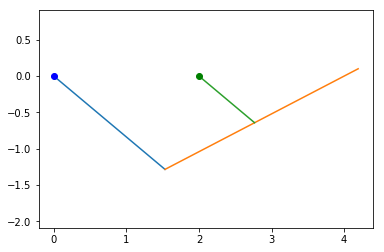

q
array([[ 1.6382925 ],
       [-1.14716942],
       [ 4.33679258],
       [ 0.16359272],
       [ 2.81914625],
       [-0.57358471],
       [11.95549528],
       [11.95549528]])


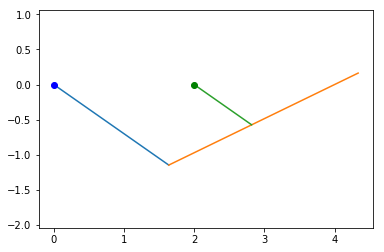

q
array([[ 1.73204064],
       [-1.00001762],
       [ 4.47704102],
       [ 0.21034302],
       [ 2.86602032],
       [-0.50000881],
       [12.04276167],
       [12.04276167]])


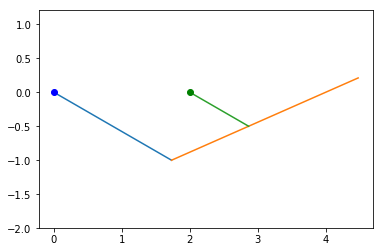

q
array([[ 1.81260691],
       [-0.8452551 ],
       [ 4.61094715],
       [ 0.23608294],
       [ 2.90630346],
       [-0.42262755],
       [12.13002806],
       [12.13002806]])


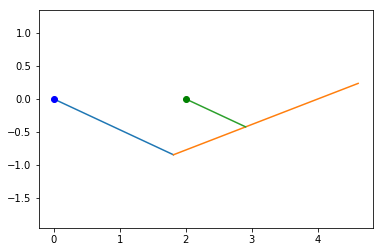

q
array([[ 1.87937818],
       [-0.68405968],
       [ 4.73450871],
       [ 0.23693418],
       [ 2.93968909],
       [-0.34202984],
       [12.21729444],
       [12.21729444]])


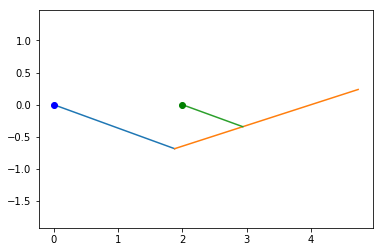

q
array([[ 1.93184627],
       [-0.51765817],
       [ 4.84206846],
       [ 0.21076945],
       [ 2.96592314],
       [-0.25882908],
       [12.30456083],
       [12.30456083]])


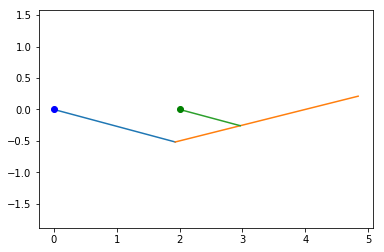

q
array([[ 1.96961187],
       [-0.34731697],
       [ 4.92666024],
       [ 0.15851394],
       [ 2.98480594],
       [-0.17365849],
       [12.39182722],
       [12.39182722]])


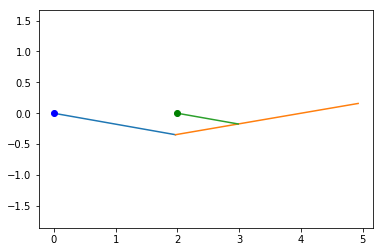

q
array([[ 1.99238756],
       [-0.17433249],
       [ 4.98114046],
       [ 0.08519805],
       [ 2.99619378],
       [-0.08716624],
       [12.47909361],
       [12.47909361]])


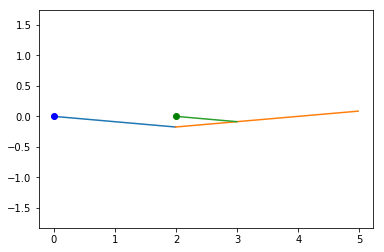

q
array([[ 2.00000000e+00],
       [-2.12287183e-05],
       [ 5.00000000e+00],
       [ 1.06143592e-05],
       [ 3.00000000e+00],
       [-1.06143592e-05],
       [ 1.25663600e+01],
       [ 1.25663600e+01]])


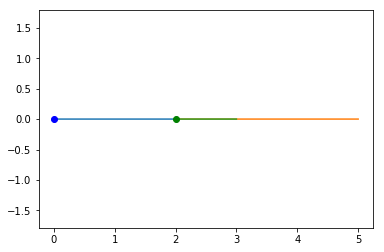

q
array([[ 1.99239126],
       [ 0.17429019],
       [ 4.98114955],
       [-0.08517832],
       [ 2.99619563],
       [ 0.0871451 ],
       [12.65362639],
       [12.65362639]])


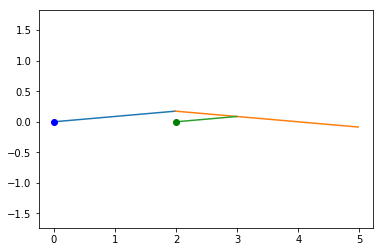

q
array([[ 1.96961924],
       [ 0.34727516],
       [ 4.92667743],
       [-0.15849838],
       [ 2.98480962],
       [ 0.17363758],
       [12.74089278],
       [12.74089278]])


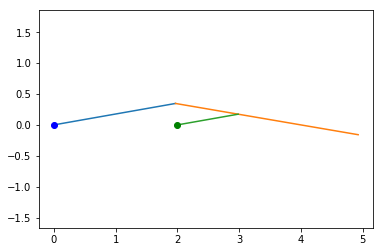

q
array([[ 1.93185726],
       [ 0.51761716],
       [ 4.84209213],
       [-0.21075979],
       [ 2.96592863],
       [ 0.25880858],
       [12.82815917],
       [12.82815917]])


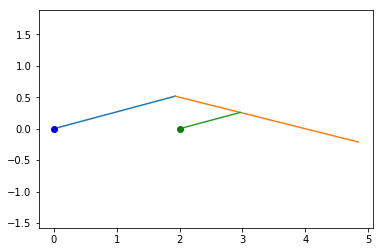

q
array([[ 1.8793927 ],
       [ 0.68401978],
       [ 4.73453708],
       [-0.23693114],
       [ 2.93969635],
       [ 0.34200989],
       [12.91542556],
       [12.91542556]])


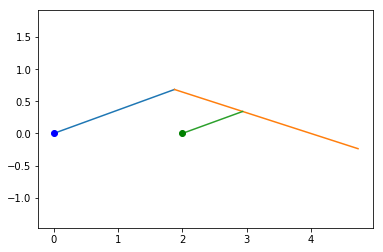

q
array([[ 1.81262486],
       [ 0.84521662],
       [ 4.61097866],
       [-0.2360863 ],
       [ 2.90631243],
       [ 0.42260831],
       [13.00269194],
       [13.00269194]])


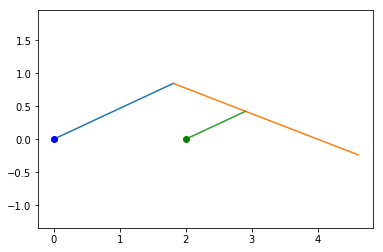

q
array([[ 1.73206186],
       [ 0.99998085],
       [ 4.4770745 ],
       [-0.21035202],
       [ 2.86603093],
       [ 0.49999042],
       [13.08995833],
       [13.08995833]])


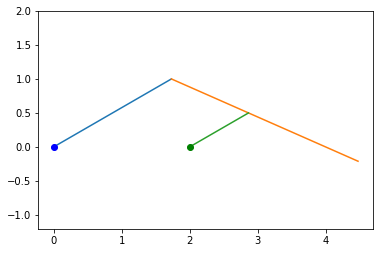

q
array([[ 1.63831686],
       [ 1.14713464],
       [ 4.33682723],
       [-0.16360628],
       [ 2.81915843],
       [ 0.57356732],
       [13.17722472],
       [13.17722472]])


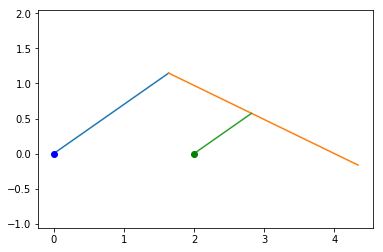

q
array([[ 1.53210329],
       [ 1.28555805],
       [ 4.19275933],
       [-0.10041073],
       [ 2.76605164],
       [ 0.64277903],
       [13.26449111],
       [13.26449111]])


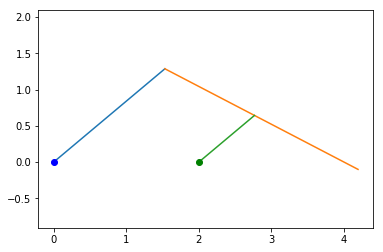

q
array([[ 1.41422951],
       [ 1.41419761],
       [ 4.0462982 ],
       [-0.0253212 ],
       [ 2.70711476],
       [ 0.70709881],
       [13.3517575 ],
       [13.3517575 ]])


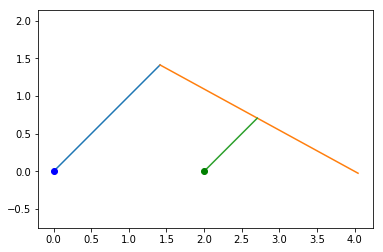

q
array([[ 1.28559261],
       [ 1.53207429],
       [ 3.89816955],
       [ 0.05747546],
       [ 2.64279631],
       [ 0.76603715],
       [13.43902389],
       [13.43902389]])


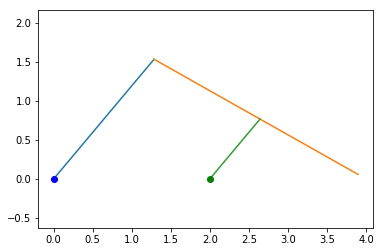

q
array([[ 1.14717159],
       [ 1.63829098],
       [ 3.74871187],
       [ 0.14430699],
       [ 2.5735858 ],
       [ 0.81914549],
       [13.52629028],
       [13.52629028]])


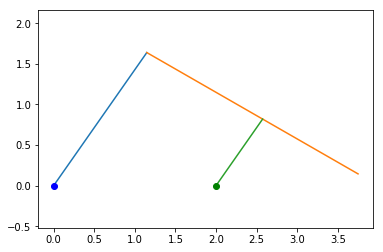

q
array([[ 1.00001992],
       [ 1.73203931],
       [ 3.59809613],
       [ 0.23203931],
       [ 2.50000996],
       [ 0.86601965],
       [13.61355667],
       [13.61355667]])


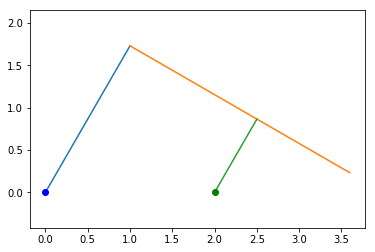

q
array([[ 0.8452575 ],
       [ 1.81260579],
       [ 3.44646482],
       [ 0.31804215],
       [ 2.42262875],
       [ 0.9063029 ],
       [13.70082306],
       [13.70082306]])


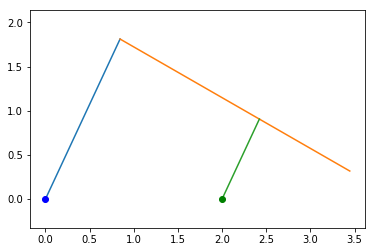

q
array([[ 0.68406217],
       [ 1.87937727],
       [ 3.29401197],
       [ 0.40013352],
       [ 2.34203109],
       [ 0.93968864],
       [13.78808944],
       [13.78808944]])


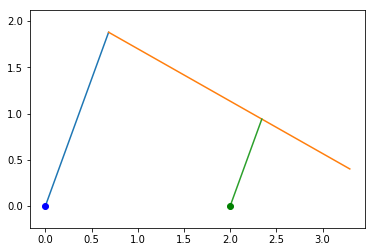

q
array([[ 0.51766073],
       [ 1.93184559],
       [ 3.14102349],
       [ 0.47652163],
       [ 2.25883037],
       [ 0.96592279],
       [13.87535583],
       [13.87535583]])


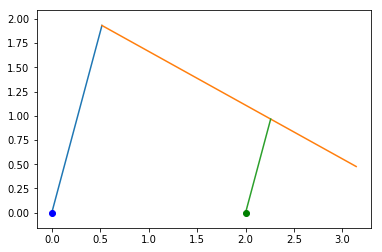

q
array([[ 0.34731958],
       [ 1.96961141],
       [ 2.98789246],
       [ 0.54575225],
       [ 2.17365979],
       [ 0.9848057 ],
       [13.96262222],
       [13.96262222]])


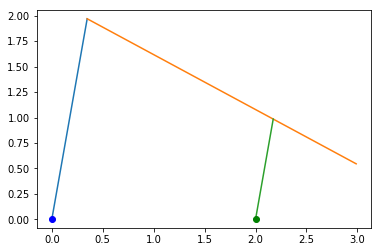

q
array([[ 0.17433513],
       [ 1.99238733],
       [ 2.83511911],
       [ 0.6066642 ],
       [ 2.08716757],
       [ 0.99619366],
       [14.04988861],
       [14.04988861]])


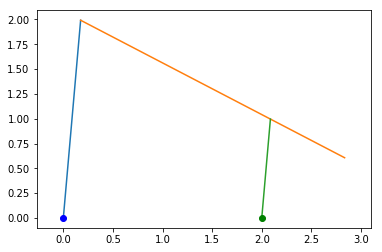

q
array([[2.38823081e-05],
       [2.00000000e+00],
       [2.68330225e+00],
       [6.58352805e-01],
       [2.00001194e+00],
       [1.00000000e+00],
       [1.41371550e+01],
       [1.41371550e+01]])


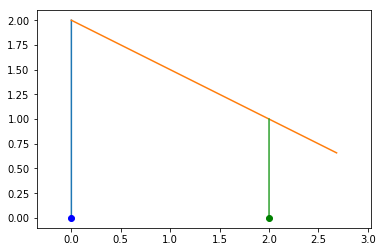

q
array([[-0.17428755],
       [ 1.99239149],
       [ 2.53312584],
       [ 0.70014046],
       [ 1.91285623],
       [ 0.99619575],
       [14.22442139],
       [14.22442139]])


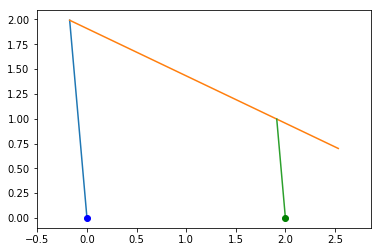

q
array([[-0.34727255],
       [ 1.9696197 ],
       [ 2.38534347],
       [ 0.73155278],
       [ 1.82636373],
       [ 0.98480985],
       [14.31168778],
       [14.31168778]])


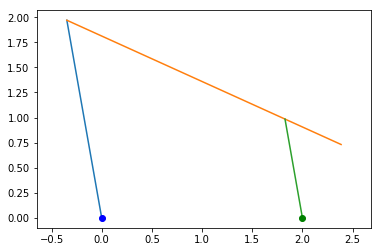

q
array([[-0.51761459],
       [ 1.93185795],
       [ 2.24076196],
       [ 0.75229923],
       [ 1.7411927 ],
       [ 0.96592897],
       [14.39895417],
       [14.39895417]])


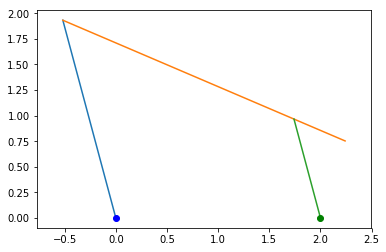

q
array([[-0.68401729],
       [ 1.87939361],
       [ 2.1002251 ],
       [ 0.76225696],
       [ 1.65799135],
       [ 0.93969681],
       [14.48622056],
       [14.48622056]])


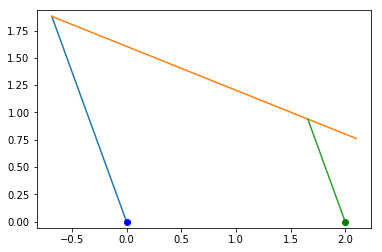

q
array([[-0.84521421],
       [ 1.81262598],
       [ 1.96459788],
       [ 0.7614571 ],
       [ 1.57739289],
       [ 0.90631299],
       [14.57348694],
       [14.57348694]])


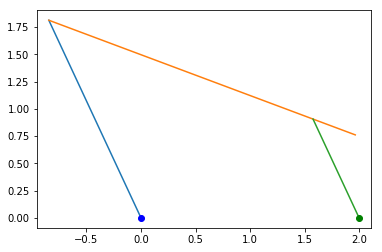

q
array([[-0.99997855],
       [ 1.73206319],
       [ 1.83475152],
       [ 0.75007266],
       [ 1.50001072],
       [ 0.8660316 ],
       [14.66075333],
       [14.66075333]])


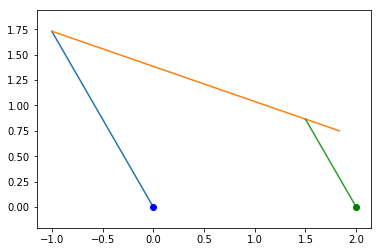

q
array([[-1.14713246],
       [ 1.63831838],
       [ 1.71154947],
       [ 0.72840763],
       [ 1.42643377],
       [ 0.81915919],
       [14.74801972],
       [14.74801972]])


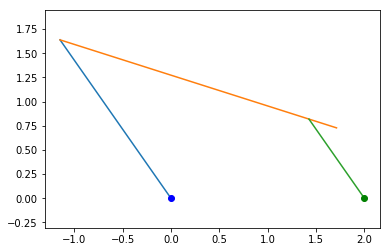

q
array([[-1.28555602],
       [ 1.532105  ],
       [ 1.59583436],
       [ 0.69688679],
       [ 1.35722199],
       [ 0.7660525 ],
       [14.83528611],
       [14.83528611]])


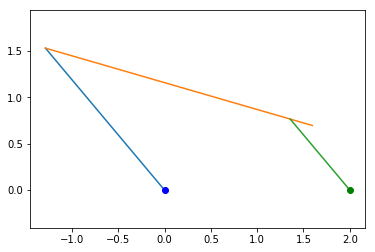

q
array([[-1.41419574],
       [ 1.41423139],
       [ 1.48841598],
       [ 0.65604591],
       [ 1.29290213],
       [ 0.70711569],
       [14.9225525 ],
       [14.9225525 ]])


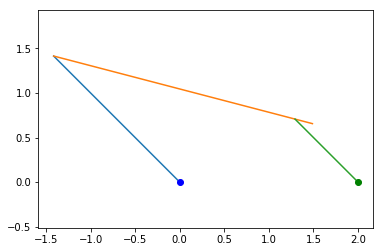

q
array([[-1.53207259],
       [ 1.28559464],
       [ 1.39006029],
       [ 0.60652214],
       [ 1.23396371],
       [ 0.64279732],
       [15.00981889],
       [15.00981889]])


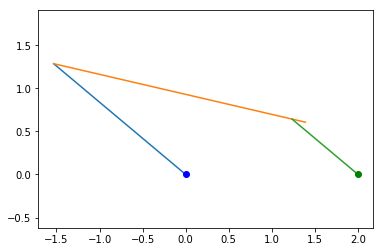

q
array([[-1.63828946],
       [ 1.14717376],
       [ 1.30147948],
       [ 0.54904452],
       [ 1.18085527],
       [ 0.57358688],
       [15.09708528],
       [15.09708528]])


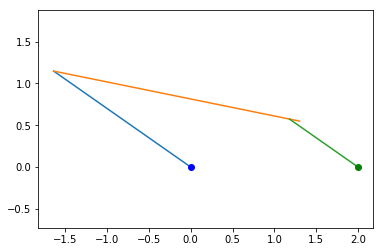

q
array([[-1.73203798],
       [ 1.00002221],
       [ 1.22332305],
       [ 0.48442433],
       [ 1.13398101],
       [ 0.50001111],
       [15.18435167],
       [15.18435167]])


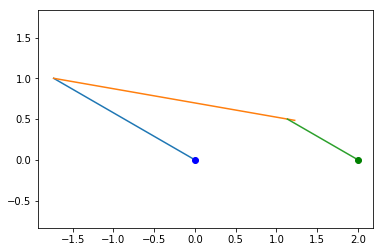

q
array([[-1.81260467],
       [ 0.84525991],
       [ 1.15616991],
       [ 0.41354534],
       [ 1.09369766],
       [ 0.42262995],
       [15.27161806],
       [15.27161806]])


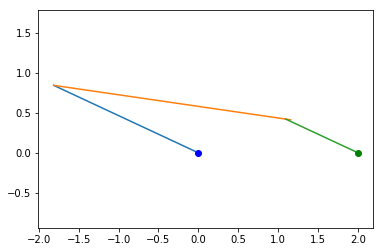

q
array([[-1.87937637],
       [ 0.68406467],
       [ 1.10052156],
       [ 0.33735394],
       [ 1.06031182],
       [ 0.34203233],
       [15.35888444],
       [15.35888444]])


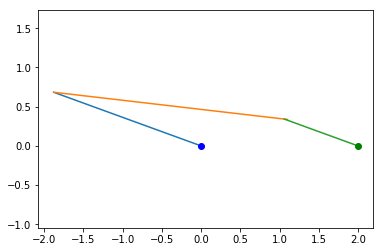

q
array([[-1.9318449 ],
       [ 0.51766329],
       [ 1.05679625],
       [ 0.25684902],
       [ 1.03407755],
       [ 0.25883165],
       [15.44615083],
       [15.44615083]])


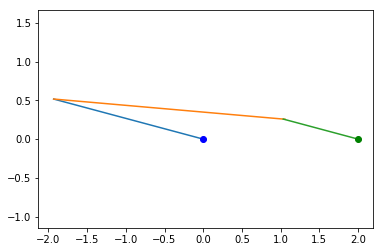

q
array([[-1.96961095],
       [ 0.3473222 ],
       [ 1.02532424],
       [ 0.17307173],
       [ 1.01519453],
       [ 0.1736611 ],
       [15.53341722],
       [15.53341722]])


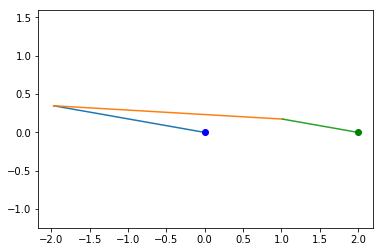

q
array([[-1.9923871 ],
       [ 0.17433777],
       [ 1.00634409],
       [ 0.08709506],
       [ 1.00380645],
       [ 0.08716889],
       [15.62068361],
       [15.62068361]])


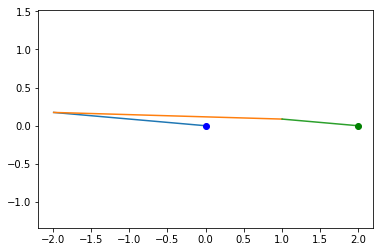

q
array([[-2.00000000e+00],
       [ 2.65358979e-05],
       [ 1.00000000e+00],
       [ 1.32679490e-05],
       [ 1.00000000e+00],
       [ 1.32679490e-05],
       [ 1.57079500e+01],
       [ 1.57079500e+01]])


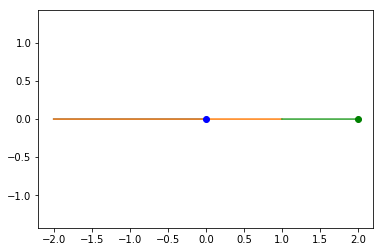

q
array([[-1.99239172],
       [-0.1742849 ],
       [ 1.00634023],
       [-0.08706869],
       [ 1.00380414],
       [-0.08714245],
       [15.79521639],
       [15.79521639]])


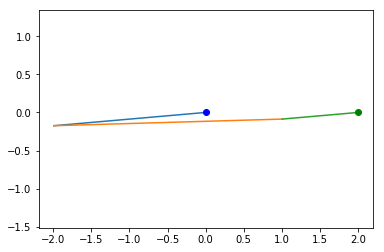

q
array([[-1.96962016],
       [-0.34726993],
       [ 1.02531656],
       [-0.17304587],
       [ 1.01518992],
       [-0.17363497],
       [15.88248278],
       [15.88248278]])


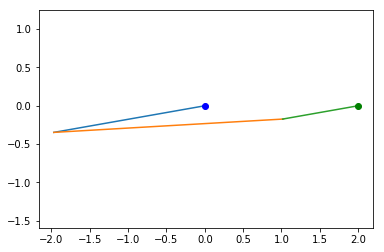

q
array([[-1.93185863],
       [-0.51761203],
       [ 1.0567848 ],
       [-0.25682399],
       [ 1.03407068],
       [-0.25880602],
       [15.96974917],
       [15.96974917]])


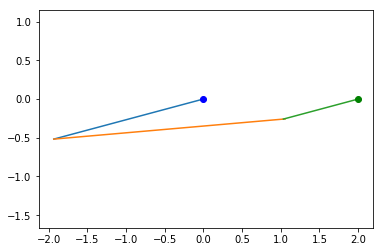

q
array([[-1.87939452],
       [-0.6840148 ],
       [ 1.10050643],
       [-0.33733006],
       [ 1.06030274],
       [-0.3420074 ],
       [16.05701556],
       [16.05701556]])


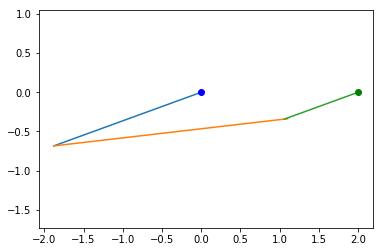

q
array([[-1.8126271 ],
       [-0.84521181],
       [ 1.15615122],
       [-0.41352293],
       [ 1.09368645],
       [-0.4226059 ],
       [16.14428194],
       [16.14428194]])


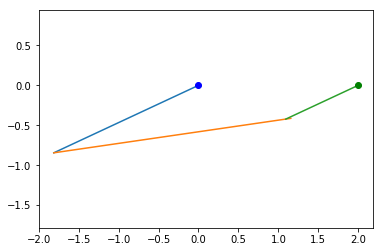

q
array([[-1.73206452],
       [-0.99997625],
       [ 1.22330093],
       [-0.48440368],
       [ 1.13396774],
       [-0.49998813],
       [16.23154833],
       [16.23154833]])


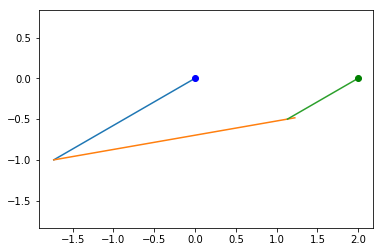

q
array([[-1.6383199 ],
       [-1.14713029],
       [ 1.3014541 ],
       [-0.54902592],
       [ 1.18084005],
       [-0.57356515],
       [16.31881472],
       [16.31881472]])


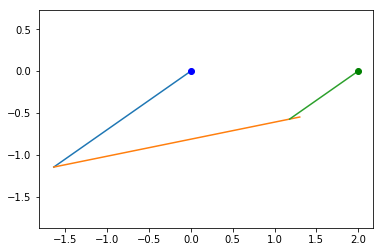

q
array([[-1.5321067 ],
       [-1.28555399],
       [ 1.39003183],
       [-0.60650583],
       [ 1.23394665],
       [-0.64277699],
       [16.40608111],
       [16.40608111]])


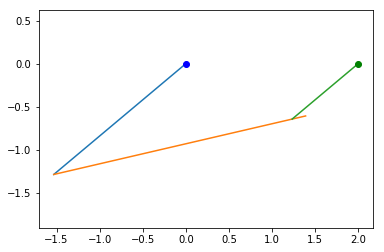

q
array([[-1.41423326],
       [-1.41419386],
       [ 1.48838466],
       [-0.65603213],
       [ 1.29288337],
       [-0.70709693],
       [16.4933475 ],
       [16.4933475 ]])


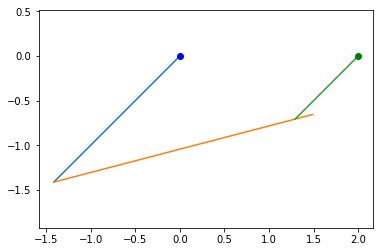

q
array([[-1.28559668],
       [-1.53207088],
       [ 1.5958004 ],
       [-0.69687576],
       [ 1.35720166],
       [-0.76603544],
       [16.58061389],
       [16.58061389]])


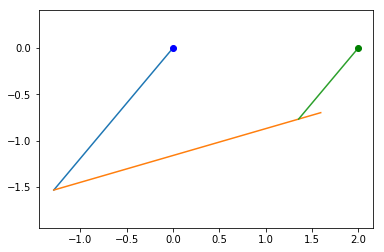

q
array([[-1.14717594],
       [-1.63828794],
       [ 1.71151311],
       [-0.72839952],
       [ 1.42641203],
       [-0.81914397],
       [16.66788028],
       [16.66788028]])


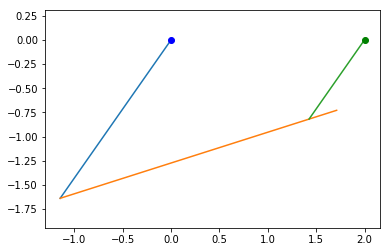

q
array([[-1.00002451],
       [-1.73203665],
       [ 1.83471301],
       [-0.75006761],
       [ 1.49998774],
       [-0.86601833],
       [16.75514667],
       [16.75514667]])


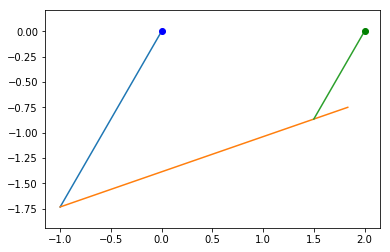

q
array([[-0.84526231],
       [-1.81260355],
       [ 1.96455747],
       [-0.76145523],
       [ 1.57736884],
       [-0.90630177],
       [16.84241306],
       [16.84241306]])


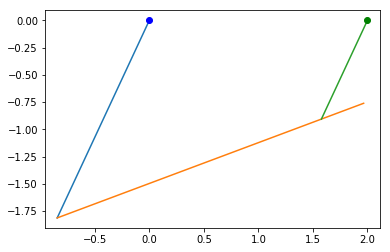

q
array([[-0.68406716],
       [-1.87937546],
       [ 2.10018307],
       [-0.76225835],
       [ 1.65796642],
       [-0.93968773],
       [16.92967944],
       [16.92967944]])


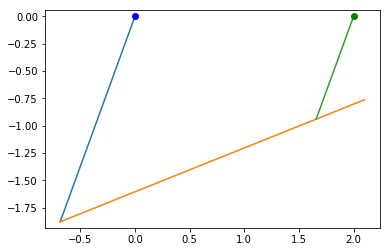

q
array([[-0.51766586],
       [-1.93184421],
       [ 2.24071857],
       [-0.7523039 ],
       [ 1.74116707],
       [-0.96592211],
       [17.01694583],
       [17.01694583]])


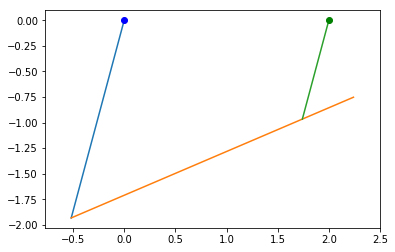

q
array([[-0.34732481],
       [-1.96961049],
       [ 2.38529898],
       [-0.73156072],
       [ 1.82633759],
       [-0.98480524],
       [17.10421222],
       [17.10421222]])


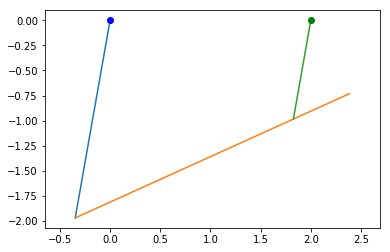

q
array([[-0.17434042],
       [-1.99238686],
       [ 2.5330805 ],
       [-0.7001516 ],
       [ 1.91282979],
       [-0.99619343],
       [17.19147861],
       [17.19147861]])


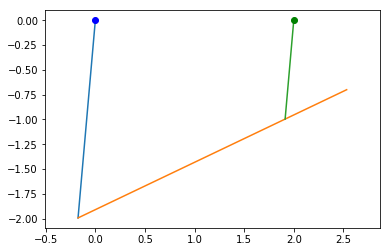

q
array([[-2.91894877e-05],
       [-2.00000000e+00],
       [ 2.68325630e+00],
       [-6.58367046e-01],
       [ 1.99998541e+00],
       [-1.00000000e+00],
       [ 1.72787450e+01],
       [ 1.72787450e+01]])


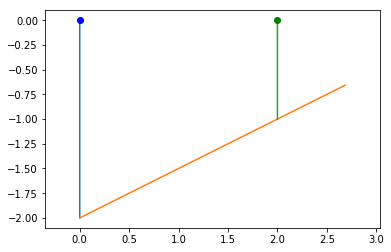

q
array([[ 0.17428226],
       [-1.99239195],
       [ 2.83507277],
       [-0.60668136],
       [ 2.08714113],
       [-0.99619598],
       [17.36601139],
       [17.36601139]])


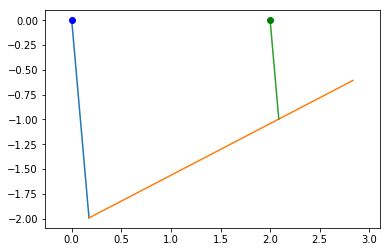

In [3]:
i = 0

while (i<200):
      
    q[6] = i*5*3.14159/180
    q[7] = i*5*3.14159/180
    q = resuelve_prob_posicion(q,meca)
    print ("q")
    pprint.pprint (q)
    dibuja_mecanismo(q,meca) 
    sleep(0.2)
    i= i+1
